# Bayesian Inference for Interleaved Randomized Benchmarking


## Introduction

This notebook gives an example of how to use Bayesian inference as a help for randomized benchmarking. The Pymc3 and Arviz python packages are used for this purpose. Priors are obtained from the fitter included in the Qiskit ``ignis.verification.randomized_benchmarking``module. A pooled and a hierarchical model are tested and compared. The model's parameters are ajusted and the error per Clifford (EPC) is estimated, together with a credible interval. For reference, an EPC value is calculated from the noisy model of the simulation.

Thes notebook is based on the examples of the ignis noise tutorial on randomized benchmarking.

In [1]:
#Import general libraries (needed for functions)
import numpy as np
import matplotlib.pyplot as plt
from IPython import display

#Import Qiskit classes
import qiskit
from qiskit.tools.monitor import job_monitor
from qiskit import Aer
from qiskit.providers.aer.noise import NoiseModel
from qiskit.providers.aer.noise.errors.standard_errors import depolarizing_error, thermal_relaxation_error

#Import the RB Functions
import qiskit.ignis.verification.randomized_benchmarking as rb

import copy
import time

# import the bayesian packages
import pymc3 as pm
import arviz as az

In [2]:
# initialize the Bayesian extension
%config InlineBackend.figure_format = 'retina'
# Initialize random number generator
RANDOM_SEED = 8927
np.random.seed(RANDOM_SEED)
az.style.use("arviz-darkgrid")

In [41]:
def obtain_priors_and_data_from_fitter(rbfit,printout = True):
    m_gates = copy.deepcopy(nCliffs)
    # We choose the count matrix corresponding to 2 Qubit RB
    Y = (np.array(rbfit._raw_data[0])*shots).astype(int)
    
    # alpha prior and bounds 
    alpha_ref = rbfit._fit[0]['params'][1]    
    alpha_lower = alpha_ref - 6*rbfit._fit[0]['params_err'][1] 
    alpha_upper = alpha_ref + 6*rbfit._fit[0]['params_err'][1] 
    
    # priors for A anbd B
    mu_AB = np.delete(rbfit._fit[0]['params'],1)
    cov_AB=np.delete(rbfit._fit[0]['params_err'],1)**2
    
    # prior for sigma theta:
    sigma_theta = 0.004 # WIP   
    if printout:
        print("priors:\nalpha_ref",alpha_ref)
        print("alpha_lower", alpha_lower, "alpha_upper", alpha_upper)
        print("A,B", mu_AB, "\ncov A,B", cov_AB)
        print("sigma_theta", sigma_theta)
    
    return m_gates, Y, alpha_ref, alpha_lower, alpha_upper, mu_AB, cov_AB, sigma_theta

In [4]:
def get_bayesian_model(model_type):
# Bayesian model
# from https://iopscience.iop.org/article/10.1088/1367-2630/17/1/013042/pdf 
# see https://docs.pymc.io/api/model.html
    
    RB_model = pm.Model()
    with RB_model:
        #Priors for unknown model parameters
        alpha = pm.Uniform("alpha",lower=alpha_lower,
                           upper=alpha_upper, testval = alpha_ref)
        
        BoundedMvNormal = pm.Bound(pm.MvNormal, lower=0.0)
        
        AB = BoundedMvNormal("AB", mu=mu_AB,testval = mu_AB,
                         cov= np.diag(cov_AB),
                         shape = (2))

        # Expected value of outcome
        GSP = AB[0]*alpha**m_gates + AB[1]
        
        if model_type == "pooled":
            total_shots = np.full(Y.shape, shots)
            theta = GSP
        
        elif model_type == "hierarchical":
            total_shots = np.full(Y.shape, shots)
            theta = pm.Beta("GSP",
                         mu=GSP,
                         sigma = sigma_theta,
                         shape = Y.shape[1])
        
        # Likelihood (sampling distribution) of observations    
        p = pm.Binomial("Counts", p=theta, observed=Y,
                            n = total_shots) 

    return RB_model

In [5]:
def get_trace(RB_model):
    # Gradient-based sampling methods
    # see also: https://docs.pymc.io/notebooks/sampler-stats.html
    # and https://docs.pymc.io/notebooks/api_quickstart.html
    with RB_model:   
        trace= pm.sample(draws = 2000, tune= 10000, target_accept=0.9, return_inferencedata=True)    

    with RB_model:
        az.plot_trace(trace);
        
    return trace

In [6]:
def get_summary(RB_model, trace, hdi_prob=.94, kind='all'):
    with RB_model:
        #  (hdi_prob=.94 is default)
        az_summary = az.summary(trace, round_to=4,  hdi_prob=hdi_prob, kind=kind )  
        
    return az_summary

In [7]:
# obtain EPC from alpha (used by plot_posterior)
def alpha_to_EPC(alpha):
        return 3*(1-alpha)/4   

In [61]:
def get_EPC_and_legends(rbfit,azs):
    EPC_Bayes = alpha_to_EPC(azs['mean']['alpha'])
    EPC_Bayes_err = EPC_Bayes - alpha_to_EPC(azs['mean']['alpha']+azs['sd']['alpha'])
    Bayes_legend ="EPC Bayes {0:.5f} ({1:.5f})".format(EPC_Bayes, EPC_Bayes_err)
    Fitter_legend ="EPC Fitter {0:.5f} ({1:.5f})".format(rbfit.fit[0]['epc']\
                                                        ,rbfit._fit[0]['epc_err'])
    if pred_epc > 0.0:
        pred_epc_legend = "EPC predicted {0:.5f}".format(pred_epc)
    else:
        pred_epc_legend = ''
    return EPC_Bayes, EPC_Bayes_err, Bayes_legend,Fitter_legend, pred_epc_legend
    
def EPC_compare_fitter_to_bayes(RB_model, azs, trace,m_name,rbfit):
    EPC_Bayes, EPC_Bayes_err, Bayes_legend,Fitter_legend, pred_epc_legend = get_EPC_and_legends(rbfit,azs)
    with RB_model:
        az.plot_posterior(trace,  var_names=['alpha'], round_to=4,
                          transform = alpha_to_EPC, point_estimate=None)
        plt.title("Error per Clifford  "+RB_process+"  device: "+hardware
                  +'  backend: '+backend.name()+'  model:'+m_name,
                  fontsize=12)
        plt.axvline(x=alpha_to_EPC(alpha_ref),color='red')
        if pred_epc > 0.0:
            plt.axvline(x=pred_epc,color='green') 
            plt.legend((Bayes_legend, "Higher density interval",Fitter_legend, pred_epc_legend), fontsize=10)
        else:
            plt.legend((Bayes_legend, "Higher density interval",Fitter_legend), fontsize=10 )
        
        plt.show()

In [72]:
def GSP_compare_fitter_to_bayes(RB_model, azs,m_name,rbfit):
    EPC_Bayes, EPC_Bayes_err, Bayes_legend,Fitter_legend,_ = get_EPC_and_legends(rbfit,azs)
    # plot ground state population ~ Clifford length
    fig, axes = plt.subplots(1, 1, sharex=True, figsize=(10, 6))

    axes.set_ylabel("Ground State Population")
    axes.set_xlabel("Clifford Length")
    axes.plot(m_gates, np.mean(Y/shots,axis=0), 'r.')
    axes.plot(m_gates,azs['mean']['AB[0]']*azs['mean']['alpha']**m_gates+azs['mean']['AB[1]'],'--')
    #axes.plot(m_gates,azs['mean']['GSP'],'--') # WIP
    #axes.errorbar(m_gates, azs['mean']['GSP'], azs['sd']['GSP'], linestyle='None', marker='^') # WIP
    axes.plot(m_gates,mu_AB[0]*np.power(alpha_ref,m_gates)+mu_AB[1],':') 
    for i_seed in range(nseeds):
        plt.scatter(m_gates-0.25, Y[i_seed,:]/shots, label = "data", marker="x")
    axes.legend(["Mean Observed Frequencies",
                 "Bayesian Model\n"+Bayes_legend,
                 "Fitter Model\n"+Fitter_legend],fontsize=12)
    axes.set_title(RB_process+"  device: "+hardware+'  backend: '+backend.name()+'  model:'+m_name,
                   fontsize=14) # WIP
    

In [10]:
def get_predicted_EPC(error_source):

    #Count the number of single and 2Q gates in the 2Q Cliffords
    gates_per_cliff = rb.rb_utils.gates_per_clifford(transpile_list,xdata[0],basis_gates,rb_opts['rb_pattern'][0])
    for basis_gate in basis_gates:
        print("Number of %s gates per Clifford: %f "%(basis_gate ,
                                                      np.mean([gates_per_cliff[rb_pattern[0][0]][basis_gate],
                                                               gates_per_cliff[rb_pattern[0][1]][basis_gate]])))
    # Calculate the predicted epc
    # from the known depolarizing errors on the simulation
    if error_source == "depolarization":  
        # Error per gate from noise model
        epgs_1q = {'u1': 0, 'u2': p1Q/2, 'u3': 2*p1Q/2}
        epg_2q = p2Q*3/4
        pred_epc = rb.rb_utils.calculate_2q_epc(
            gate_per_cliff=gates_per_cliff,
            epg_2q=epg_2q,
            qubit_pair=[0, 2],
            list_epgs_1q=[epgs_1q, epgs_1q])

    # using the predicted primitive gate errors from the coherence limit
    if error_source == "from_T1_T2": 
        # Predicted primitive gate errors from the coherence limit
        u2_error = rb.rb_utils.coherence_limit(1,[t1],[t2],gate1Q)
        u3_error = rb.rb_utils.coherence_limit(1,[t1],[t2],2*gate1Q)
        epg_2q = rb.rb_utils.coherence_limit(2,[t1,t1],[t2,t2],gate2Q)
        epgs_1q = {'u1': 0, 'u2': u2_error, 'u3': u3_error}
        pred_epc = rb.rb_utils.calculate_2q_epc(
            gate_per_cliff=gates_per_cliff,
            epg_2q=epg_2q,
            qubit_pair=[0, 1],
            list_epgs_1q=[epgs_1q, epgs_1q])
    return pred_epc

In [11]:
def get_count_data(result_list):
### another way to obtain the observed counts 

    Y_list = []
    for rbseed, result in enumerate(result_list):
        row_list = []
        for c_index, c_value in enumerate(nCliffs):
            if nQ == 2: 
                list_bitstring = ['00']
            elif nQ == 3:
                list_bitstring = ['000', '100'] # when q2 measured in c1
            total_counts = 0
            for bitstring in list_bitstring:
                    total_counts += result.get_counts()[c_index][bitstring]
            row_list.append(total_counts)
        Y_list.append(row_list)    
    return np.array(Y_list)    

In [12]:
def get_and_run_seeds(rb_circs, shots, backend, coupling_map,
                      basis_gates, noise_model, retrieve_list=[]):   
    #basis_gates = ['u1','u2','u3','cx'] # use U,CX for now
    result_list = []
    transpile_list = []

    for rb_seed,rb_circ_seed in enumerate(rb_circs):
        print('Compiling seed %d'%rb_seed)
        rb_circ_transpile = qiskit.transpile(rb_circ_seed,
                                             optimization_level=0,
                                             basis_gates=basis_gates)
        print('Runing seed %d'%rb_seed)

        if retrieve_list == []:
            if noise_model == None:           
                job = qiskit.execute(rb_circ_transpile, 
                                 shots=shots,
                                 backend=backend,
                                 coupling_map=coupling_map,
                                 basis_gates=basis_gates)
            else:
                job = qiskit.execute(rb_circ_transpile, 
                                 shots=shots,
                                 backend=backend,
                                 coupling_map=coupling_map,
                                 noise_model=noise_model,
                                 basis_gates=basis_gates)                        
            job_monitor(job)
        else:
            job = backend.retrieve_job(retrieve_list[rb_seed])

        result_list.append(job.result())
        transpile_list.append(rb_circ_transpile)    

    print("Finished Real Jobs")
    return result_list, transpile_list

In [13]:
# WIP save somewhere else or see if data can be extracted from downloaded jobs
ibmq_belem_list=["6068136ef55c8d75d3fbaf63","606818f4d346d1e7686b99bd",'60681ffb35159b20c4150d32',
              '6068279f2fc7408534badeac','60682f36d346d10adb6b9a90','6068375cd346d11fe86b9ad5',
              '60683b88152e3a80963cbf91','60683fd3d5f9d6e952f7bbb4','606843b0ceea649957b9719c',
              '606847c2d346d11f866b9b4e','60684c211b50b181b2263e97','6068510df55c8d4259fbb16a',
              '6068555ef55c8d5106fbb186','60685aa6062a6e24ec1ff364','60685ee6e01e589b73c0d888',
              '606862c6ceea64dc96b97273']
ibmq_lima_list=['6060ff4af55c8de4ebfb6704','606100a9d5f9d604b3f77140',
           '606102a37d904ddd511eb04a','6061059bdab16ca4494fe152','60610651dab16c11534fe159',
           '60610696dab16ca10f4fe15c','6061079c7d904d0fe41eb07b','6061085935159b488d14c45f',
           '60610952e01e583f88c08d94','606109b81b50b1b80225f45d']
ibmqx2_3Q_list = []

## Parameters of the RB Run <a name='select_params_RB'></a>


- **nseeds:** The number of seeds. For each seed you will get a separate list of output circuits in rb_circs.
- **length_vector:** The length vector of Clifford lengths. Must be in ascending order. RB sequences of increasing length grow on top of the previous sequences.
- **rb_pattern:** A list of the form [[i,j],[k],...] which will make simultaneous RB sequences where Qi,Qj are a 2-qubit RB sequence and Qk is a 1-qubit sequence, etc. The number of qubits is the sum of the entries. For 'regular' RB the qubit_pattern is just [[0]],[[0,1]].
- **length_multiplier:** If this is an array it scales each rb_sequence by the multiplier.
- **seed_offset:** What to start the seeds at (e.g. if we want to add more seeds later).
- **align_cliffs:**  If true adds a barrier across all qubits in rb_pattern after each set of cliffords.

In [14]:
RB_process = "3_Q RB"

if RB_process == "3_Q RB":
    #Number of qubits
    nQ = 3
    #There are 3 qubits: Q0,Q1,Q2.
    #2Q RB on Q0,Q2 and 1Q RB on Q1
    rb_pattern = [[0,2],[1]] # because 3 qubits
    #Do three times as many 1Q Cliffords
    length_multiplier = [1,3]
    #Interleaved Clifford gates (2-qubits and 1-qubit)
    interleaved_gates = [['h 0', 'cx 0 1'],['x 0']]

else:
    print("NOT SUPPORTED HERE")
    #Number of qubits
    nQ = 2
    #There are 2 qubits: Q0,Q1.
    #2Q RB Q0,Q1
    rb_pattern = [[0,1]]
    length_multiplier = 1



In [15]:
RB_process

'3_Q RB'

In [16]:
rb_pattern

[[0, 2], [1]]

In [17]:
#Number of Cliffords in the sequence (start, stop, steps)
nCliffs = np.arange(1,200,20)

#Number of seeds (random sequences)
nseeds=4
#retrieve_list=ibmq_belem_list
#retrieve_list=ibmq_lima_list
retrieve_list=[] # if you want a new runs on hardware or if no hardware
if retrieve_list != []:
    nseeds = len(retrieve_list)
nseeds

4

In [20]:
from qiskit import  QuantumRegister, QuantumCircuit

In [21]:
qregs_02 = QuantumRegister(2)
circ_02 = QuantumCircuit(qregs_02, name='circ_02')
circ_02.h(qregs_02[0])
circ_02.cx(qregs_02[0], qregs_02[1])
circ_02.draw()

┌───┐     
q0_0: ┤ H ├──■──
      └───┘┌─┴─┐
q0_1: ─────┤ X ├
           └───┘

In [22]:
qregs_1 = QuantumRegister(1)
circ_1 = QuantumCircuit(qregs_1, name='circ_1')
circ_1.x(qregs_1[0])
circ_1.draw()

┌───┐
q1_0: ┤ X ├
      └───┘

## Generate the RB sequences <a name='gen_RB_seq'></a>

In order to generate the RB sequences **rb_circs**, which is a list of lists of quantum circuits, 
we run the function `rb.randomized_benchmarking_seq`.

This function returns:

- **rb_circs:** A list of lists of circuits for the rb sequences (separate list for each seed).
- **xdata:** The Clifford lengths (with multiplier if applicable).

In [23]:
rb_opts = {}
rb_opts['length_vector'] = nCliffs
rb_opts['nseeds'] = nseeds
rb_opts['rb_pattern'] = rb_pattern
rb_opts['length_multiplier'] = length_multiplier
#rb_opts['align_cliffs'] = True
rb_opts['interleaved_elem'] = [circ_02, circ_1]
rb_original_circs, xdata, rb_interleaved_circs = rb.randomized_benchmarking_seq(**rb_opts)

In [24]:
#Original RB circuits
print (rb_original_circs[0][0])

      ┌───┐┌───┐               ┌─────┐┌───┐                        ░        »
qr_0: ┤ X ├┤ S ├────────────■──┤ SDG ├┤ H ├───────■────────────────░────────»
      ├───┤├───┤  ░  ┌───┐  │  └┬───┬┘└─░─┘┌───┐  │    ░  ┌───┐┌─┐ ░        »
qr_1: ┤ X ├┤ H ├──░──┤ Z ├──┼───┤ H ├───░──┤ Z ├──┼────░──┤ Z ├┤M├──────────»
      ├───┤├───┤┌───┐├───┤┌─┴─┐┌┴───┴┐┌───┐└───┘┌─┴─┐┌───┐├───┤└╥┘ ░ ┌─────┐»
qr_2: ┤ Y ├┤ S ├┤ H ├┤ S ├┤ X ├┤ SDG ├┤ H ├─────┤ X ├┤ H ├┤ S ├─╫──░─┤ SDG ├»
      └───┘└───┘└───┘└───┘└───┘└─────┘└───┘     └───┘└───┘└───┘ ║  ░ └─────┘»
cr: 3/══════════════════════════════════════════════════════════╩═══════════»
                                                                2           »
«                ┌───┐┌───┐     ┌─────┐┌───┐       ┌─┐        
«qr_0: ───────■──┤ H ├┤ S ├──■──┤ SDG ├┤ X ├───────┤M├────────
«             │  └───┘└───┘  │  └─────┘└───┘       └╥┘        
«qr_1: ───────┼──────────────┼──────────────────────╫─────────
«      ┌───┐┌─┴─┐┌───┐┌───┐┌─┴─┐┌─────┐┌───┐┌─

In [25]:
#Interleaved RB circuits
print (rb_interleaved_circs[0][0])

      ┌───┐┌───┐               ┌─────┐┌───┐                        ░ ┌───┐   »
qr_0: ┤ X ├┤ S ├────────────■──┤ SDG ├┤ H ├───────■────────────────░─┤ H ├───»
      ├───┤├───┤  ░  ┌───┐  │  └──░──┘├───┤┌───┐  │    ░  ┌───┐ ░  ░ ├───┤ ░ »
qr_1: ┤ X ├┤ H ├──░──┤ X ├──┼─────░───┤ Z ├┤ H ├──┼────░──┤ X ├─░────┤ Z ├─░─»
      ├───┤├───┤┌───┐├───┤┌─┴─┐┌─────┐├───┤└───┘┌─┴─┐┌───┐├───┤ ░  ░ └───┘ ░ »
qr_2: ┤ Y ├┤ S ├┤ H ├┤ S ├┤ X ├┤ SDG ├┤ H ├─────┤ X ├┤ H ├┤ S ├────░─────────»
      └───┘└───┘└───┘└───┘└───┘└─────┘└───┘     └───┘└───┘└───┘    ░         »
cr: 3/═══════════════════════════════════════════════════════════════════════»
                                                                             »
«                 ░         ┌─────┐ ┌───┐           ┌───┐┌───┐     ┌─────┐┌───┐»
«qr_0: ──■────────░──────■──┤ SDG ├─┤ H ├────────■──┤ H ├┤ S ├──■──┤ SDG ├┤ X ├»
«        │  ┌───┐ ░  ░   │  └─┬─┬─┘ └───┘        │  └───┘└───┘  │  └─────┘└───┘»
«qr_1: ──┼──┤ X ├────░───┼────┤M├─────────────

# Skip if no credentials

In [ ]:
from qiskit import IBMQ
IBMQ.load_account()
provider = IBMQ.get_provider(hub='ibm-q')
#provider.backends()

In [ ]:
device = provider.get_backend('ibmqx2') # type here hardware backend
properties = device.properties()
coupling_map = device.configuration().coupling_map

In [ ]:
# use real device
basis_gates = ['id', 'rz', 'sx', 'x', 'cx', 'reset']
backend = device
hardware = device.name()
noise_model = None
shots = 2**9

In [ ]:
# use a noise model corresponding to the chosen real device backend
basis_gates = ['id', 'rz', 'sx', 'x', 'cx', 'reset']
hardware = device.name() 
backend = Aer.get_backend('qasm_simulator')
shots = 2**9
noise_model = NoiseModel.from_backend(properties)
retrieve_list=[] # nothing to retrieve

# Determine model. Skip when hardware based model

In [26]:
hardware = "none"
backend = Aer.get_backend('qasm_simulator')
shots = 2**9
noise_model = NoiseModel()

retrieve_list=[] # nothing to retrieve
coupling_map=None

if RB_process == "3_Q RB":
    # 3-Q RB case
    #use a noise model with depolarization
    #Add depolarizing noise to the simulation
    basis_gates = ['u1','u2','u3','cx'] # use U,CX for now
    error_source = 'depolarization'    
    p1Q = 0.002 
    p2Q = 0.01 
    noise_model.add_all_qubit_quantum_error(depolarizing_error(p1Q, 1), 'u2')
    noise_model.add_all_qubit_quantum_error(depolarizing_error(2*p1Q, 1), 'u3')
    noise_model.add_all_qubit_quantum_error(depolarizing_error(p2Q, 2), 'cx')    
    
else:
    print("NOT SUPPORTED HERE")
    # Using a noise model with T1/T2 thermal relaxation error
    #Add T1/T2 noise to the simulation
    basis_gates = ['u1','u2','u3','cx'] # use U,CX for now
    error_source = 'from_T1_T2'
    t1 = 100.
    t2 = 80.
    gate1Q = 0.2 # this was doubled with respect to the original example
    gate2Q = 1.0 # this was doubled with respect to the original example
    noise_model.add_all_qubit_quantum_error(thermal_relaxation_error(t1,t2,gate1Q), 'u2')
    noise_model.add_all_qubit_quantum_error(thermal_relaxation_error(t1,t2,2*gate1Q), 'u3')
    noise_model.add_all_qubit_quantum_error(
        thermal_relaxation_error(t1,t2,gate2Q).tensor(thermal_relaxation_error(t1,t2,gate2Q)), 'cx')

 # Execute the RB sequences

In [29]:
original_result_list, original_transpile_list = get_and_run_seeds(rb_circs=rb_original_circs,
                                               shots=shots,
                                               backend = backend,
                                               coupling_map = coupling_map,
                                               basis_gates = basis_gates,
                                               noise_model = noise_model,
                                               retrieve_list=retrieve_list)                                                

Compiling seed 0
Runing seed 0
Job Status: job has successfully run
Compiling seed 1
Runing seed 1
Job Status: job has successfully run
Compiling seed 2
Runing seed 2
Job Status: job has successfully run
Compiling seed 3
Runing seed 3
Job Status: job has successfully run
Finished Real Jobs


In [30]:
interleaved_result_list, interleaved_transpile_list = get_and_run_seeds(rb_circs=rb_interleaved_circs,
                                               shots=shots,
                                               backend = backend,
                                               coupling_map = coupling_map,
                                               basis_gates = basis_gates,
                                               noise_model = noise_model,
                                               retrieve_list=retrieve_list)                                                

Compiling seed 0
Runing seed 0
Job Status: job has successfully run
Compiling seed 1
Runing seed 1
Job Status: job has successfully run
Compiling seed 2
Runing seed 2
Job Status: job has successfully run
Compiling seed 3
Runing seed 3
Job Status: job has successfully run
Finished Real Jobs


## Fit the RB results and calculate the gate fidelity <a name='fit_RB'></a>

### Get statistics about the survival probabilities

The results in **result_list** should fit to an exponentially decaying function $A \cdot \alpha ^ m + B$, where $m$ is the Clifford length.

From $\alpha$ we can calculate the **Error per Clifford (EPC)**:
$$ EPC = \frac{2^n-1}{2^n} (1-\alpha)$$
(where $n=nQ$ is the number of qubits).

##### select all seeds or a part of them WIP
start,stop,step = 0,nseeds,1
nseeds

In [31]:
#Create the original and interleaved RB fitter
original_rb_fit = rb.RBFitter(original_result_list, xdata, rb_opts['rb_pattern'])
interleaved_rb_fit = rb.RBFitter(interleaved_result_list, xdata, rb_opts['rb_pattern'])

### Calculate the interleaved gate error fidelity

From the values of $\alpha$ and $\alpha_C$ we obtain the gate error of the interleaved Clifford $c$, and $r_C=1-$(average gate fidelity of the interleaved Clifford $C$), is estimated by:
$$ EPC^{est} = r_C^{est} = \frac{(2^n-1)(1-\alpha_C/\alpha)}{2^n}$$
and must lie in the range given by certain systematic error bounds: 
$$[r_C^{est}-E,r_C^{est}+E]$$ 
for each of the patterns.

In [33]:
#Calculate the joint fitter
joint_rb_fit = rb.InterleavedRBFitter(original_result_list, interleaved_result_list, xdata, rb_opts['rb_pattern'])

In [32]:
title_plot =RB_process+"  device: "+hardware+'  backend: '+backend.name()
title_plot

'3_Q RB  device: none  backend: qasm_simulator'

In [34]:
#Print the joint fitter parameters
for patt_ind, pattern in enumerate(rb_pattern):
    print ('pattern:', patt_ind, '-', len(pattern), 'qubit interleaved RB:', joint_rb_fit.fit_int[patt_ind])

pattern: 0 - 2 qubit interleaved RB: {'alpha': 0.9769767887374156, 'alpha_err': 0.0013008607689118682, 'alpha_c': 0.9660110904132976, 'alpha_c_err': 0.0016302580619764167, 'epc_est': 0.008418085094649003, 'epc_est_err': 0.0015941410423620703, 'systematic_err': 0.02611673179922766, 'systematic_err_L': -0.017698646704578658, 'systematic_err_R': 0.03453481689387666}
pattern: 1 - 1 qubit interleaved RB: {'alpha': 0.9974798777838292, 'alpha_err': 0.000229219040804225, 'alpha_c': 0.9937768177380997, 'alpha_c_err': 9.910053577674678e-05, 'epc_est': 0.0018562078936152915, 'epc_est_err': 0.00012478625873855854, 'systematic_err': 0.0018562078936152915, 'systematic_err_L': 0.0, 'systematic_err_R': 0.003712415787230583}


#### verify the EPC_est error calculation
from: rb.InterleavedRBFitter

epc_est_err = ((nrb - 1) / nrb) * (alpha_c / alpha) \
                * (np.sqrt(alpha_err_sq + alpha_c_err_sq))

In [239]:
3*(0.9769767887374156/0.9660110904132976)/4*(np.sqrt(0.0013008607689118682**2 + 0.0016302580619764167**2))

0.001582002011137519

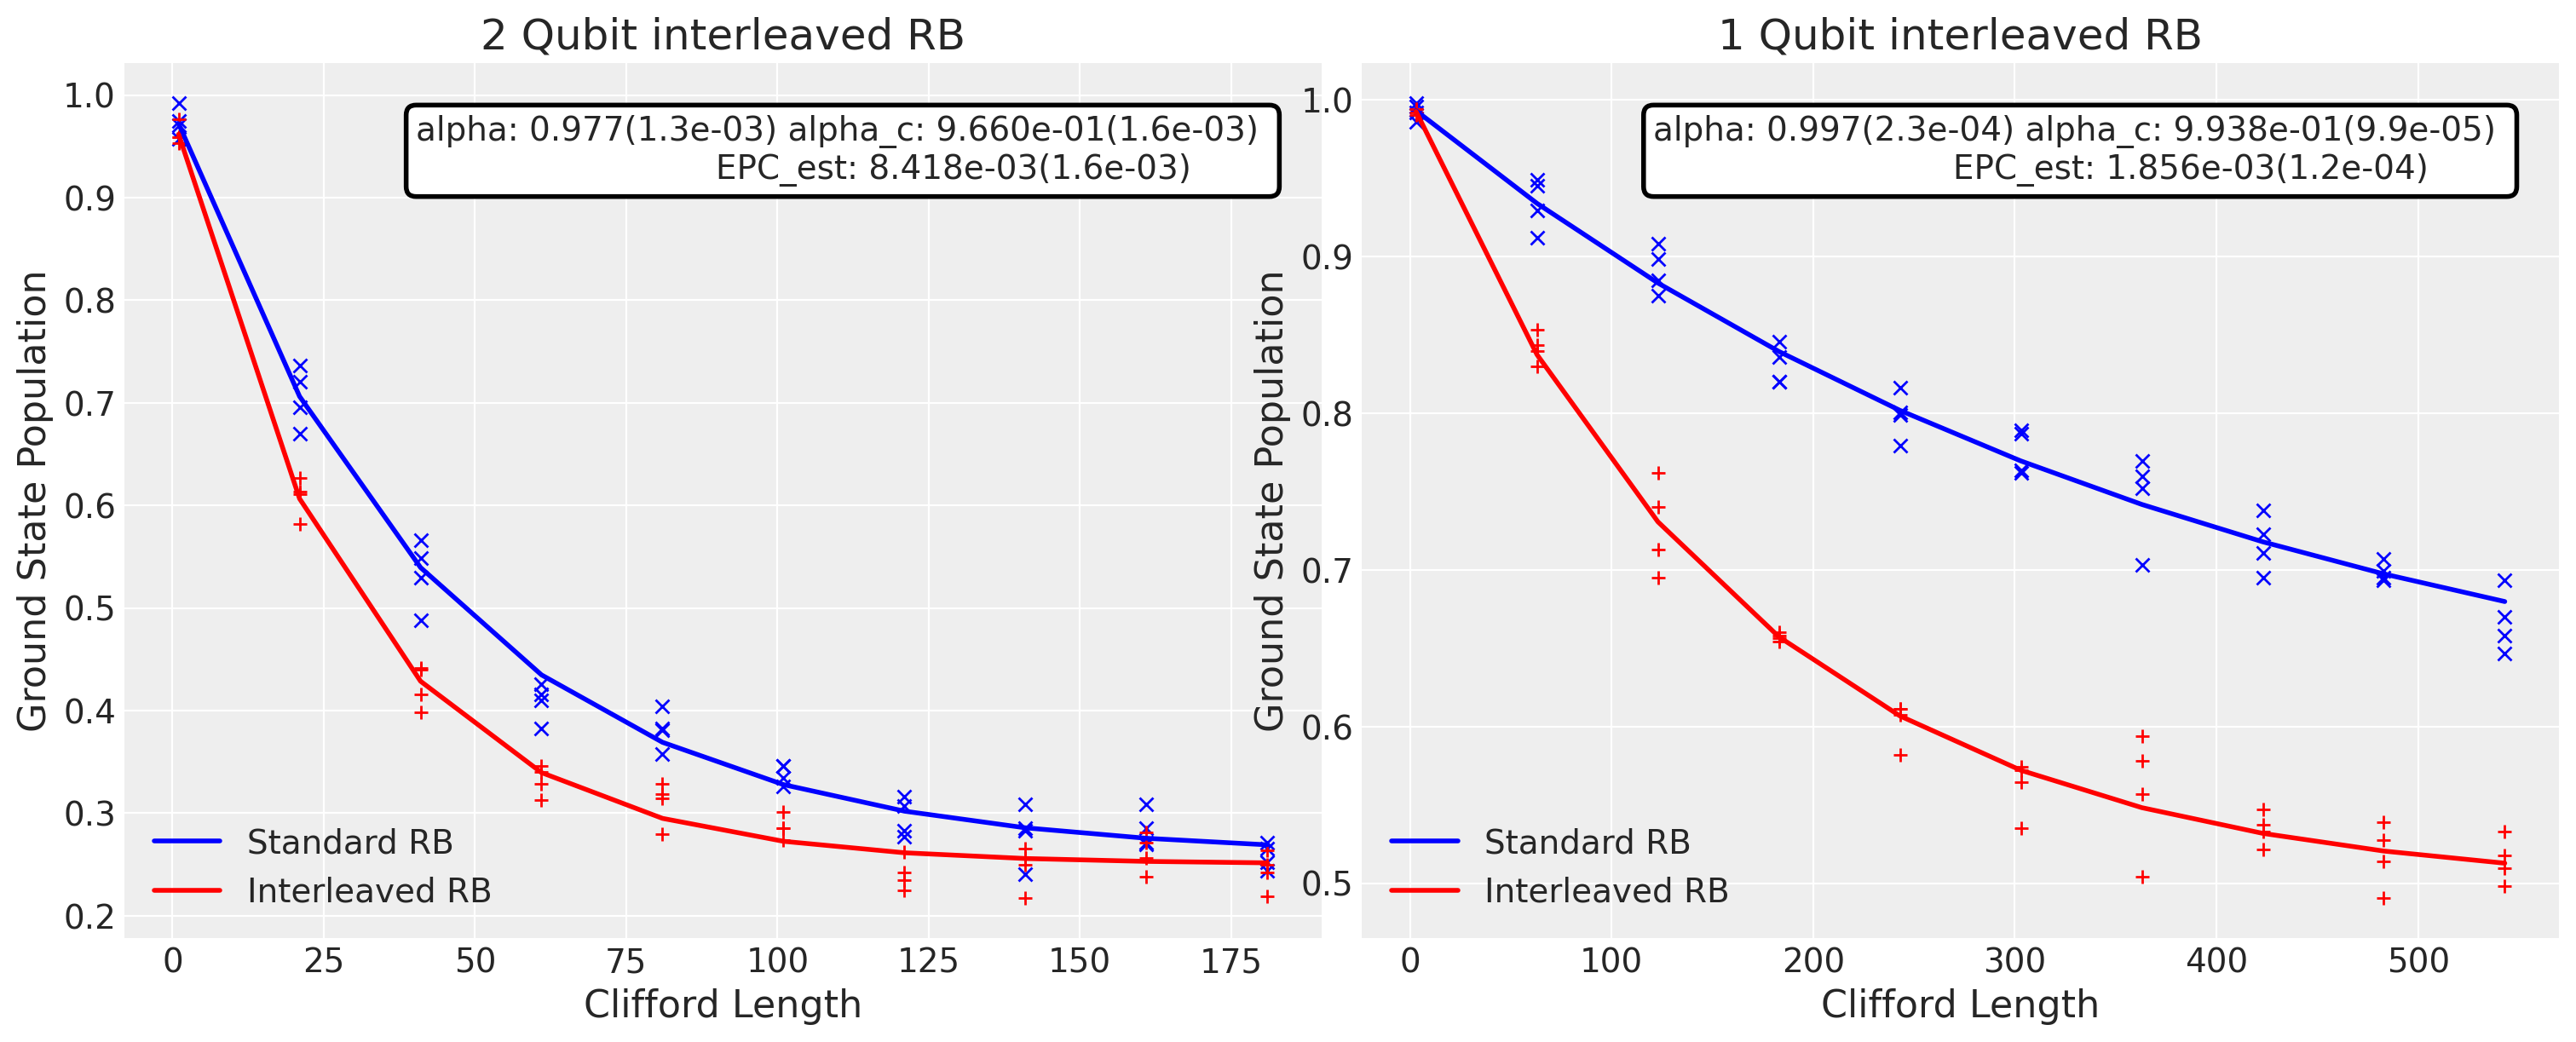

In [35]:
#Plot the joint RB data
plt.figure(figsize=(15, 6))

for i in range(2):
    ax = plt.subplot(1, 2, i+1)
    pattern_ind = i

    # Plot the essence by calling plot_rb_data
    joint_rb_fit.plot_rb_data(pattern_ind, ax=ax, add_label=True, show_plt=False)

    # Add title and label
    ax.set_title('%d Qubit interleaved RB'%(len(rb_opts['rb_pattern'][i])), fontsize=18)

plt.show()

##  Bayesian inference

## Original

In [218]:
m_gates, Y, alpha_ref, alpha_lower, alpha_upper, mu_AB, cov_AB, sigma_theta =\
    obtain_priors_and_data_from_fitter(rbfit = original_rb_fit, printout = True)

priors:
alpha_ref 0.9769767887374156
alpha_lower 0.9691716241239443 alpha_upper 0.9847819533508868
A,B [0.73062032 0.25826869] 
cov A,B [1.98351452e-04 9.07965194e-05]
sigma_theta 0.004


In [219]:
### a check of the count matrix # not working for 3 qubits WIP?
np.sum((Y == (get_count_data(original_result_list)))*1) == Y.size

True

In [220]:
Y

array([[490, 343, 281, 218, 183, 177, 142, 145, 158, 125],
       [508, 356, 290, 213, 207, 167, 157, 158, 138, 136],
       [497, 369, 271, 210, 196, 177, 145, 123, 146, 139],
       [499, 377, 250, 196, 195, 171, 162, 146, 139, 129]])

### pooled model

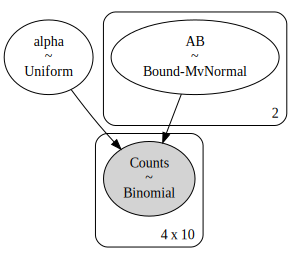

In [221]:
pooled = get_bayesian_model("pooled")
pm.model_to_graphviz(pooled)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [AB, alpha]


Sampling 4 chains for 10_000 tune and 2_000 draw iterations (40_000 + 8_000 draws total) took 71 seconds.


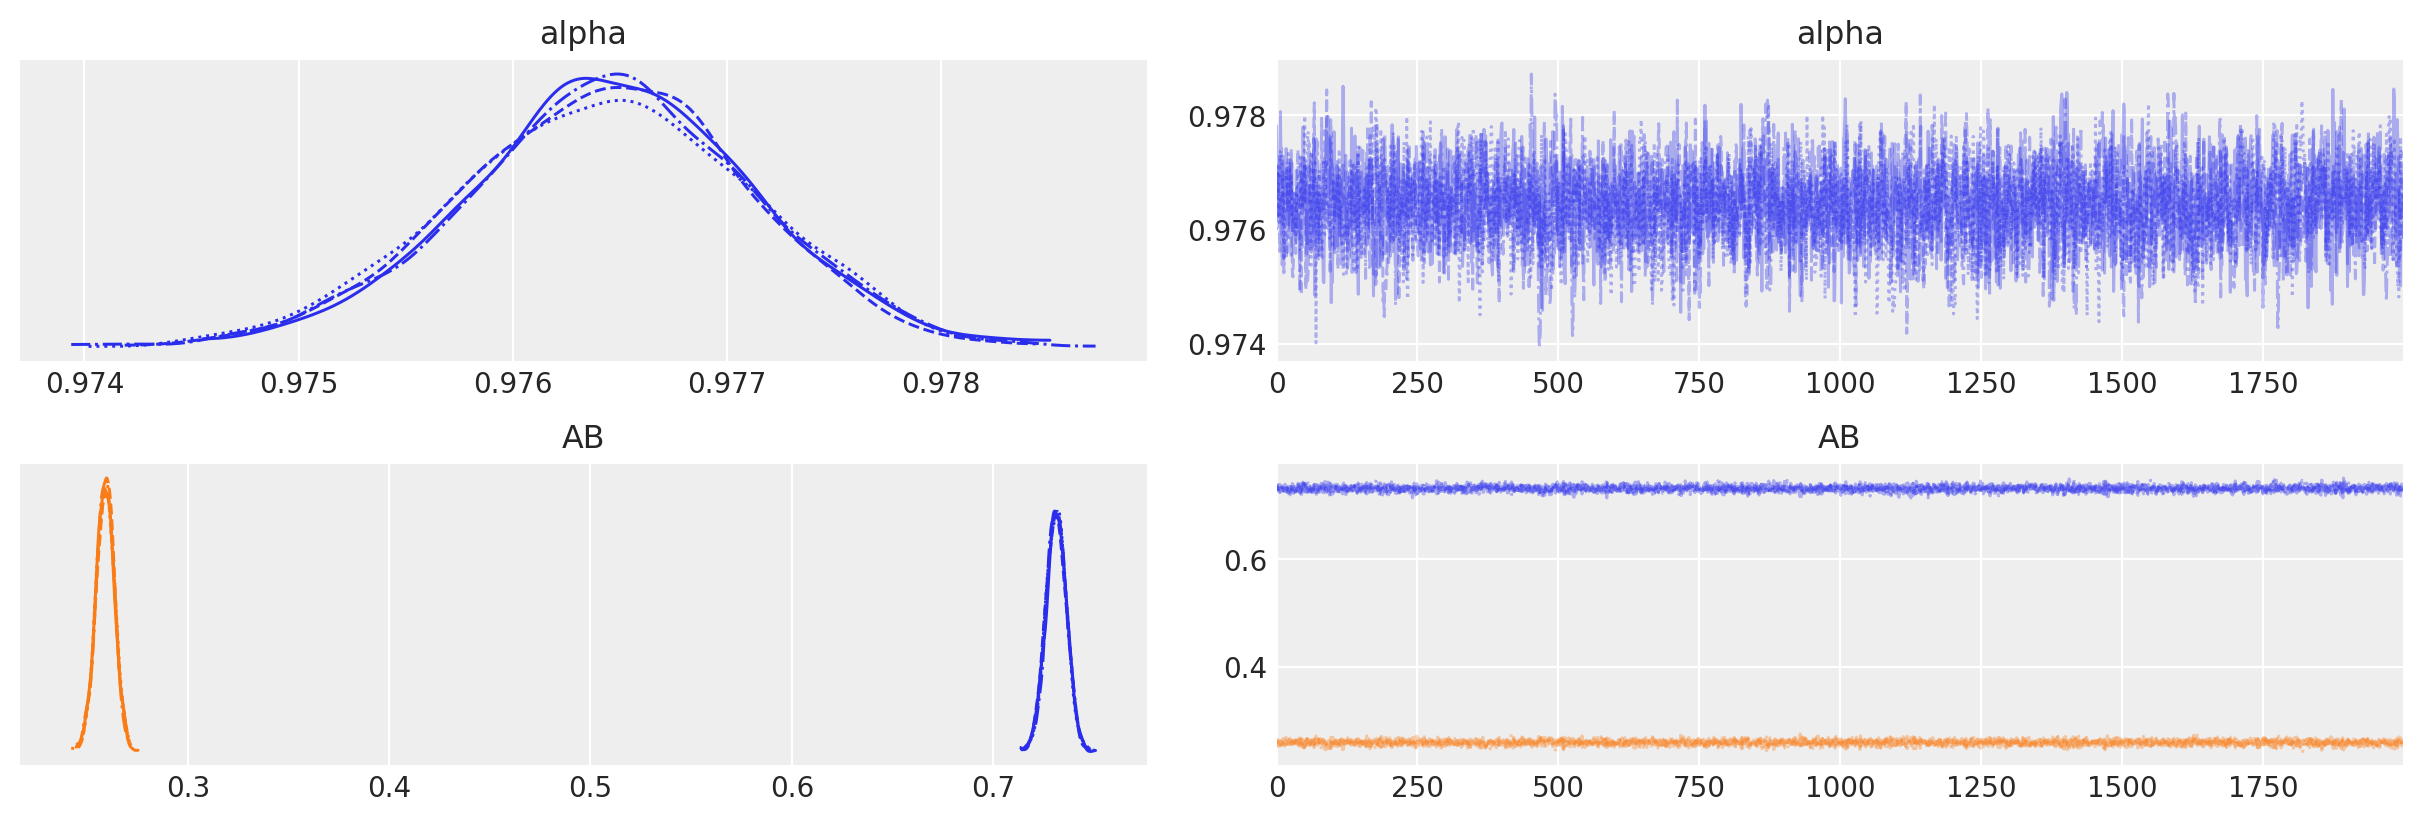

In [222]:
trace_p = get_trace(pooled)

In [223]:
azp_summary = get_summary(pooled, trace_p)
azp_summary

mean      sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd   ess_bulk  \
alpha  0.9764  0.0007  0.9751   0.9777     0.0000   0.0000  3283.9188   
AB[0]  0.7314  0.0051  0.7222   0.7412     0.0001   0.0001  3356.3502   
AB[1]  0.2589  0.0045  0.2508   0.2681     0.0001   0.0001  2928.1974   

        ess_tail   r_hat  
alpha  3366.2305  1.0013  
AB[0]  3634.9620  1.0004  
AB[1]  3313.9321  1.0003

### hierarchical model

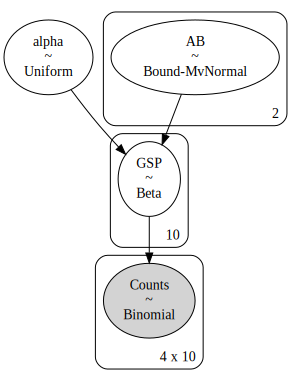

In [240]:
hierarchical = get_bayesian_model("hierarchical")
pm.model_to_graphviz(hierarchical)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [GSP, AB, alpha]


Sampling 4 chains for 10_000 tune and 2_000 draw iterations (40_000 + 8_000 draws total) took 133 seconds.
There was 1 divergence after tuning. Increase `target_accept` or reparameterize.


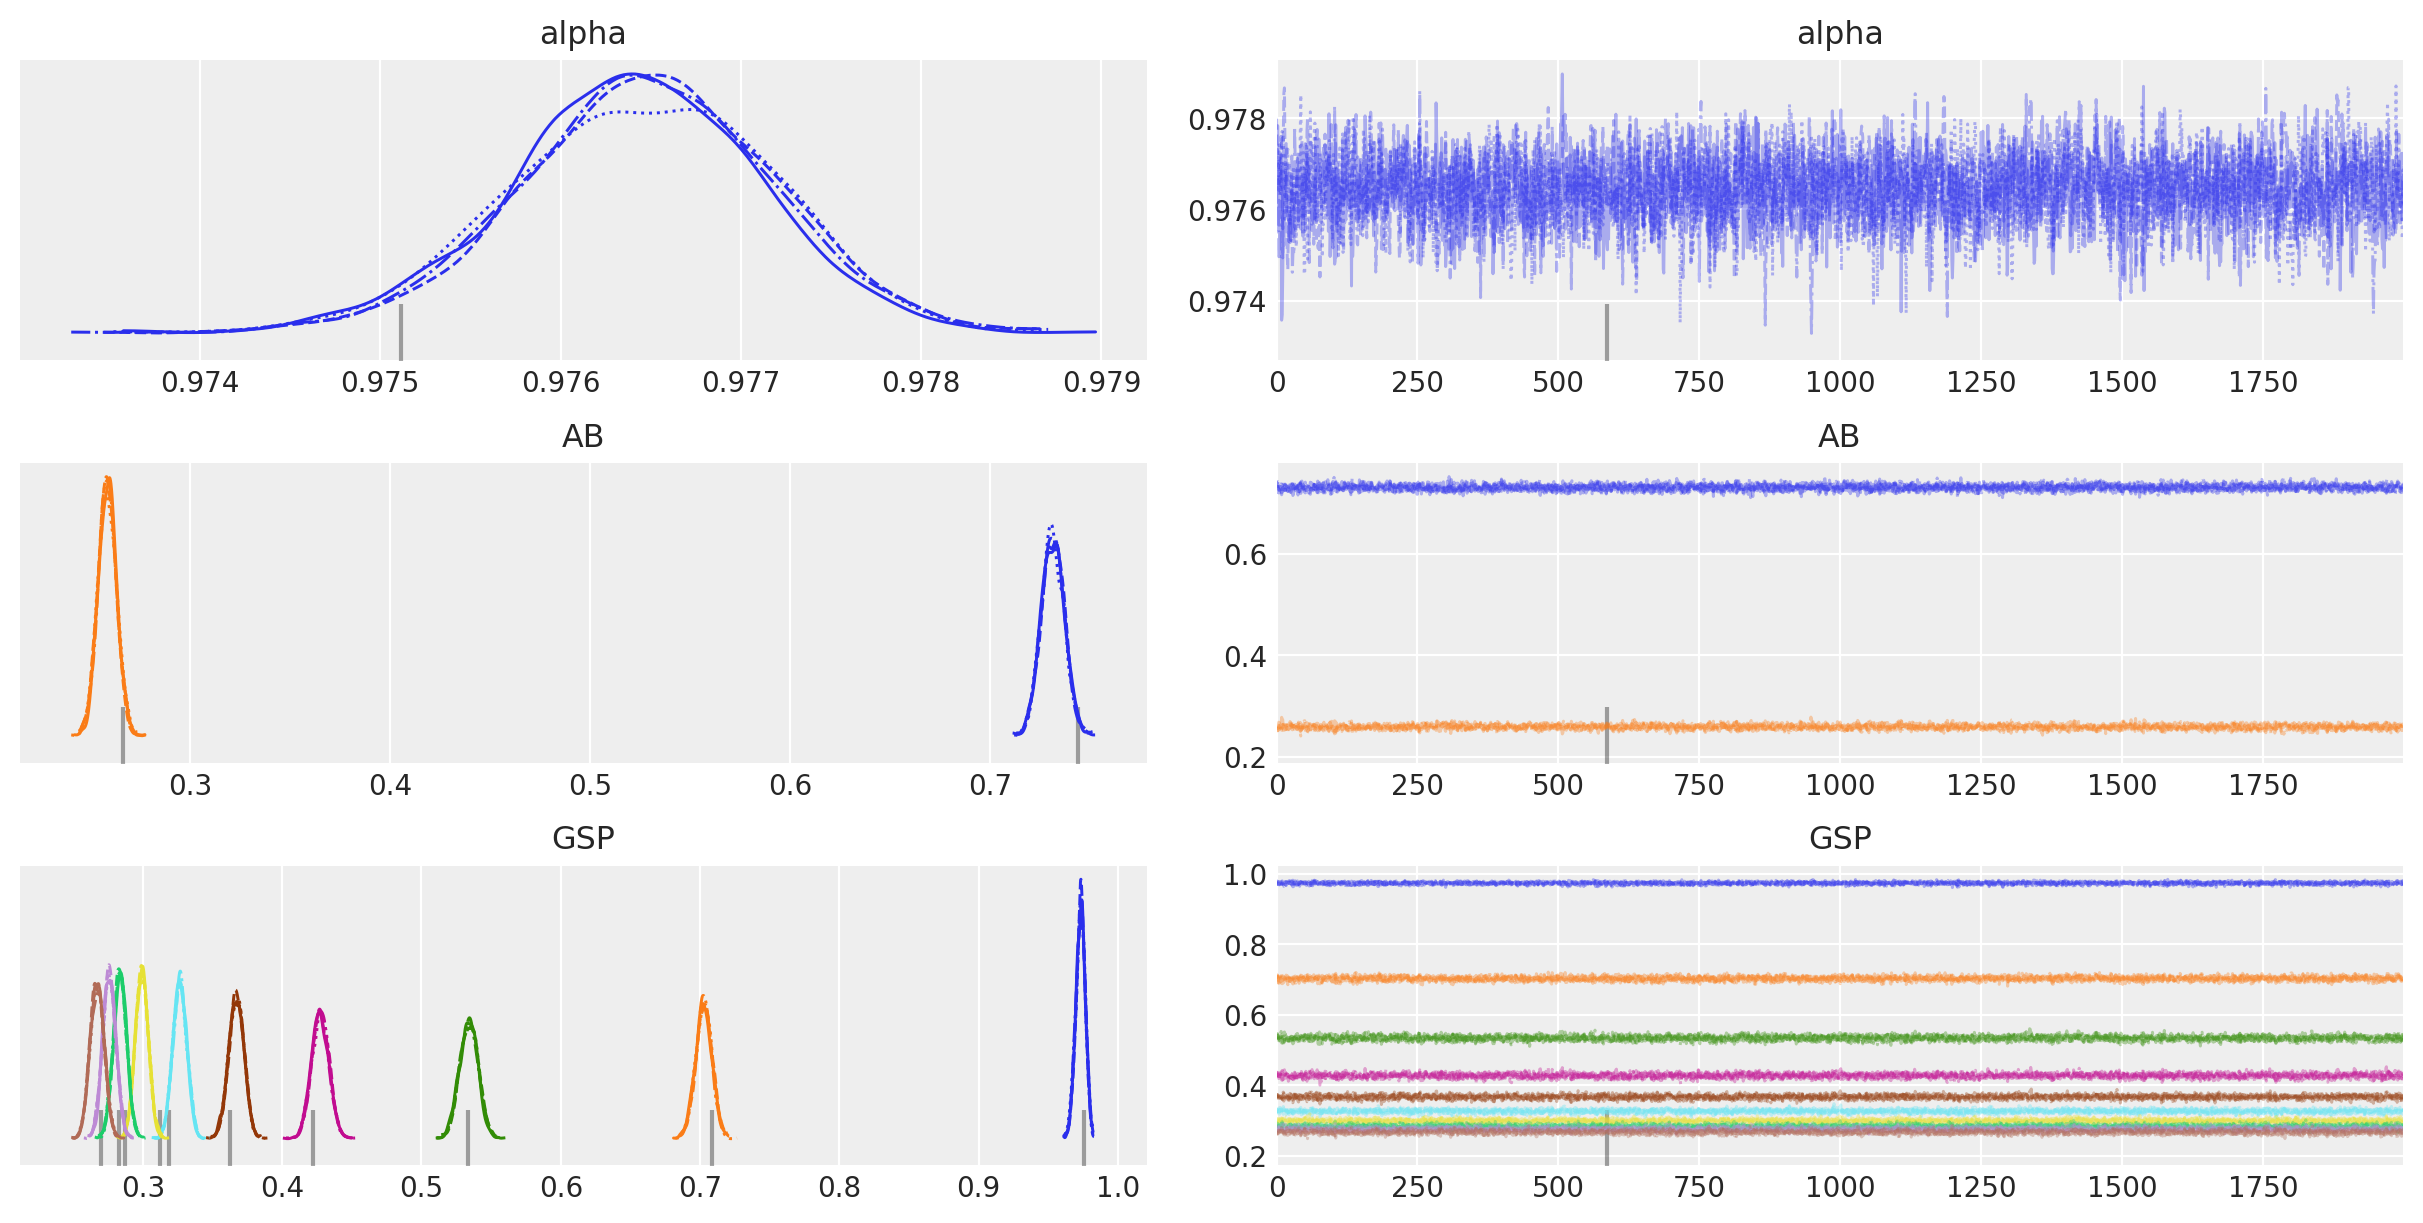

In [241]:
trace_h = get_trace(hierarchical)

In [242]:
azh_summary = get_summary(hierarchical, trace_h)
azh_summary

mean      sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd   ess_bulk  \
alpha   0.9764  0.0007  0.9750   0.9777     0.0000   0.0000  2763.6382   
AB[0]   0.7315  0.0057  0.7208   0.7420     0.0001   0.0001  4610.3036   
AB[1]   0.2587  0.0046  0.2502   0.2674     0.0001   0.0001  3061.8783   
GSP[0]  0.9731  0.0034  0.9665   0.9794     0.0000   0.0000  7711.0635   
GSP[1]  0.7027  0.0058  0.6920   0.7140     0.0001   0.0001  3947.4900   
GSP[2]  0.5340  0.0066  0.5215   0.5462     0.0001   0.0001  3419.0792   
GSP[3]  0.4273  0.0062  0.4160   0.4391     0.0001   0.0001  3503.2538   
GSP[4]  0.3670  0.0055  0.3568   0.3772     0.0001   0.0001  3784.9985   
GSP[5]  0.3265  0.0050  0.3173   0.3358     0.0001   0.0001  4260.2268   
GSP[6]  0.2993  0.0047  0.2902   0.3077     0.0001   0.0001  4374.1726   
GSP[7]  0.2835  0.0047  0.2745   0.2922     0.0001   0.0000  5013.5545   
GSP[8]  0.2758  0.0048  0.2669   0.2848     0.0001   0.0001  4262.1656   
GSP[9]  0.2671  0.0050  0.2580   0.2766     0.0001   0.0001  4090.5823   

         ess_tail   r_hat  
alpha   4162.3413  1.0011  
AB[0]   5256.0528  1.0007  
AB[1]   4352.2993  1.0008  
GSP[0]  5608.8657  1.0011  
GSP[1]  5254.6021  1.0012  
GSP[2]  5107.3007  1.0006  
GSP[3]  5058.7145  1.0001  
GSP[4]  5321.8628  1.0002  
GSP[5]  5725.9559  0.9997  
GSP[6]  5543.0387  0.9998  
GSP[7]  5165.8327  0.9998  
GSP[8]  5159.7798  1.0006  
GSP[9]  5119.6366  1.0003

### compare models
ref: https://docs.pymc.io/notebooks/model_comparison.html

In [243]:
# Leave-one-out Cross-validation (LOO) comparison
df_comp_loo = az.compare({"hierarchical": trace_h, "pooled": trace_p})
df_comp_loo

C:\Users\decpi\Anaconda3\envs\QK20\lib\site-packages\arviz\stats\stats.py:145: UserWarning: The default method used to estimate the weights for each model,has changed from BB-pseudo-BMA to stacking
  warnings.warn(


rank         loo     p_loo     d_loo  weight        se  \
hierarchical     0 -157.929337  5.929949  0.000000     1.0  6.286924   
pooled           1 -158.130521  4.980938  0.201184     0.0  6.345140   

                   dse  warning loo_scale  
hierarchical  0.000000    False       log  
pooled        0.323535    False       log

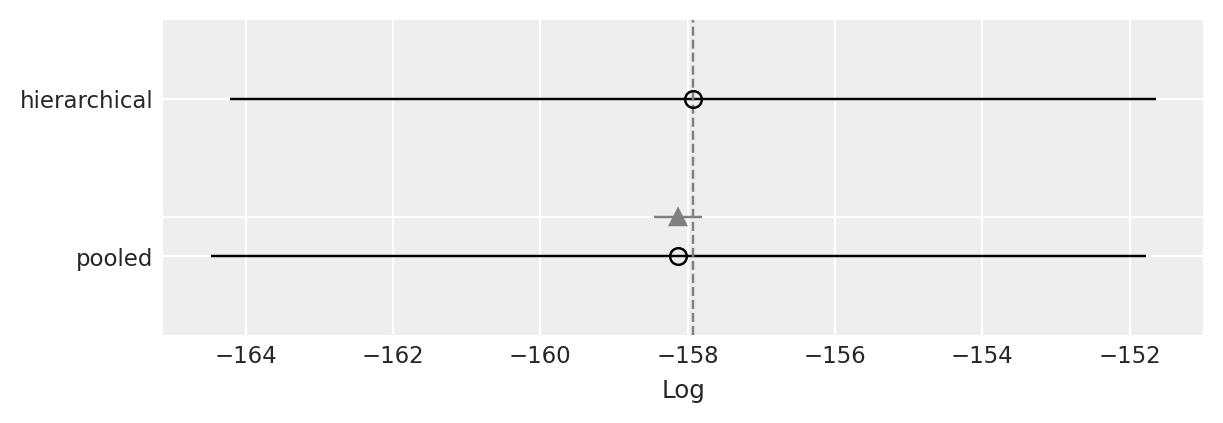

In [244]:
az.plot_compare(df_comp_loo, insample_dev=False);

In [245]:
# predict EPC from the noisy model # not for this case

pred_epc = -1 # will not appear on graphs for real device but at this point functions need value (WIP)

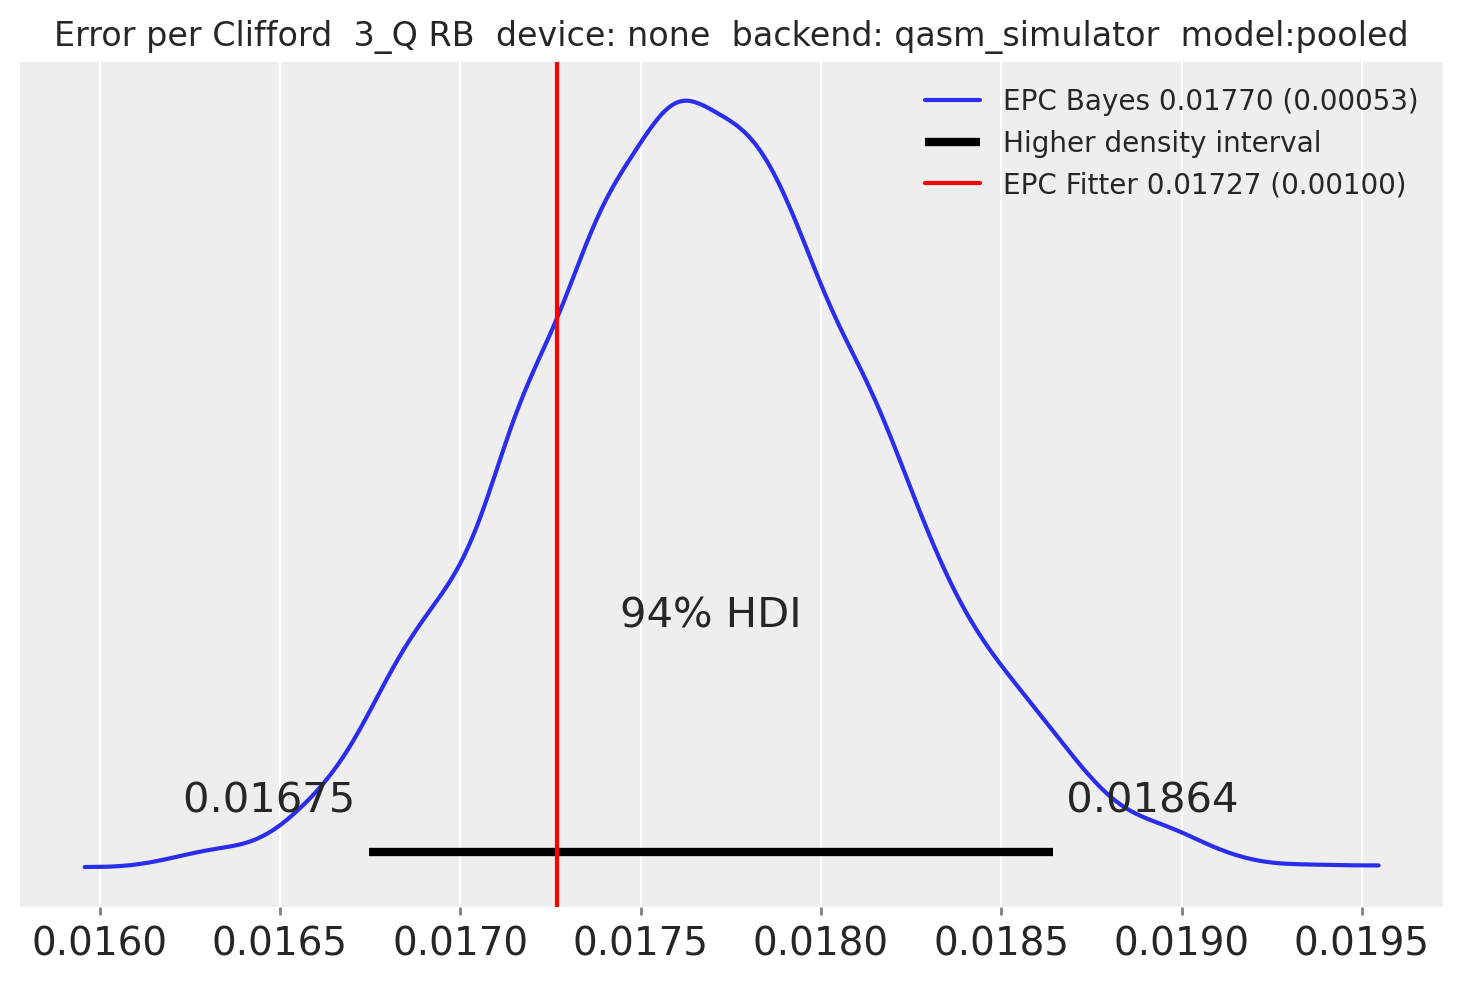

In [246]:
EPC_compare_fitter_to_bayes(pooled, azp_summary, trace_p, m_name="pooled",rbfit = original_rb_fit)

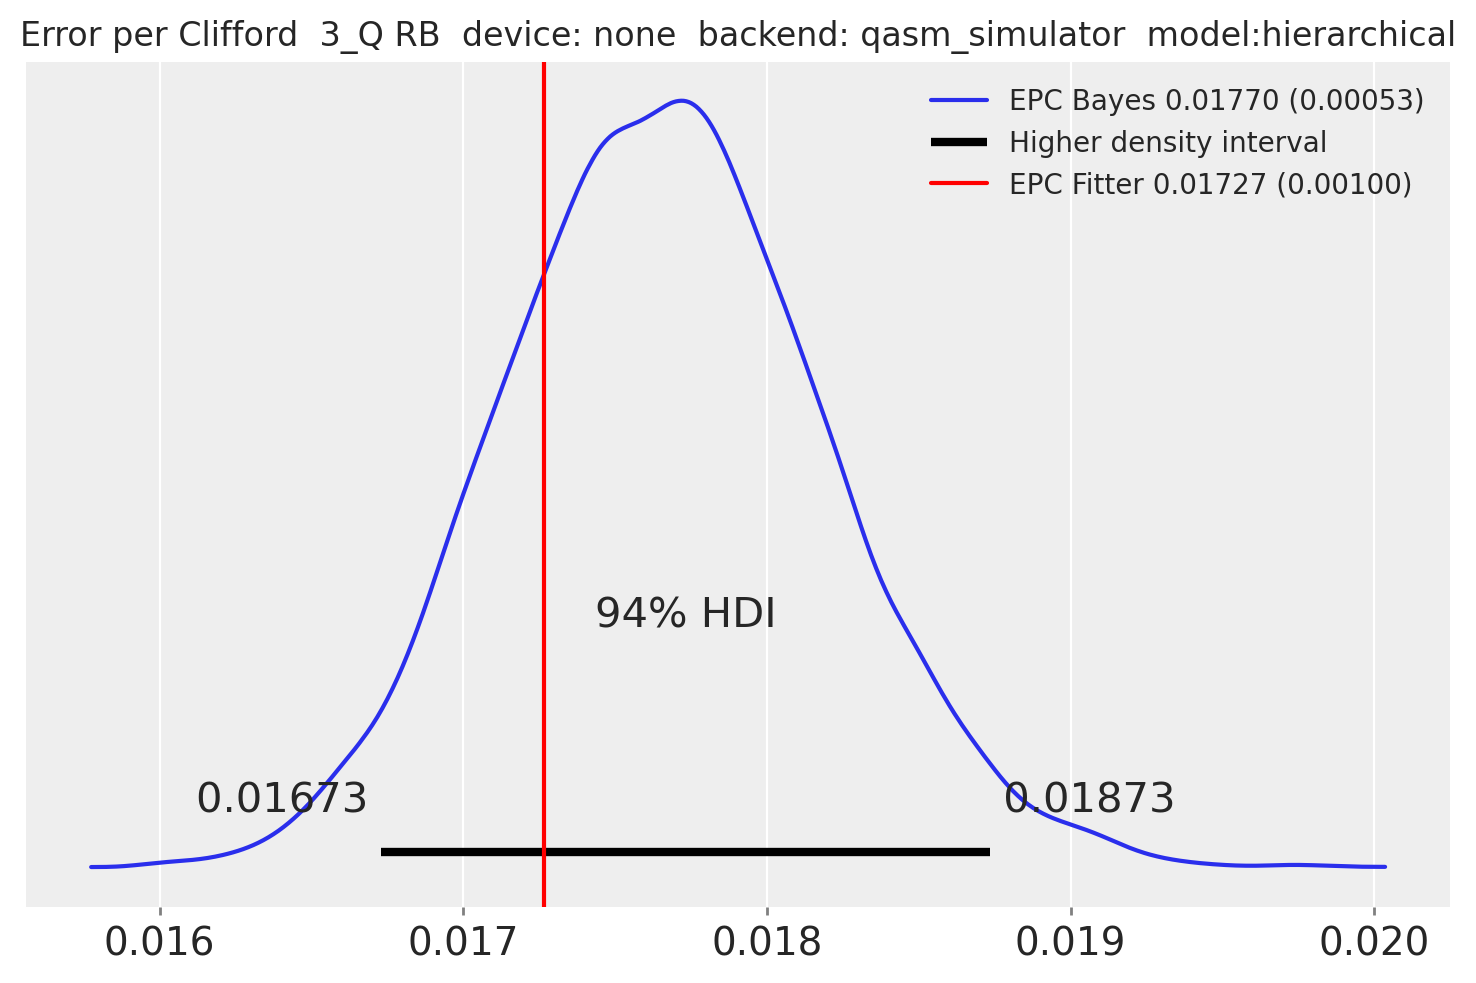

In [247]:
EPC_compare_fitter_to_bayes(hierarchical, azh_summary, trace_h,m_name='hierarchical',rbfit = original_rb_fit,)

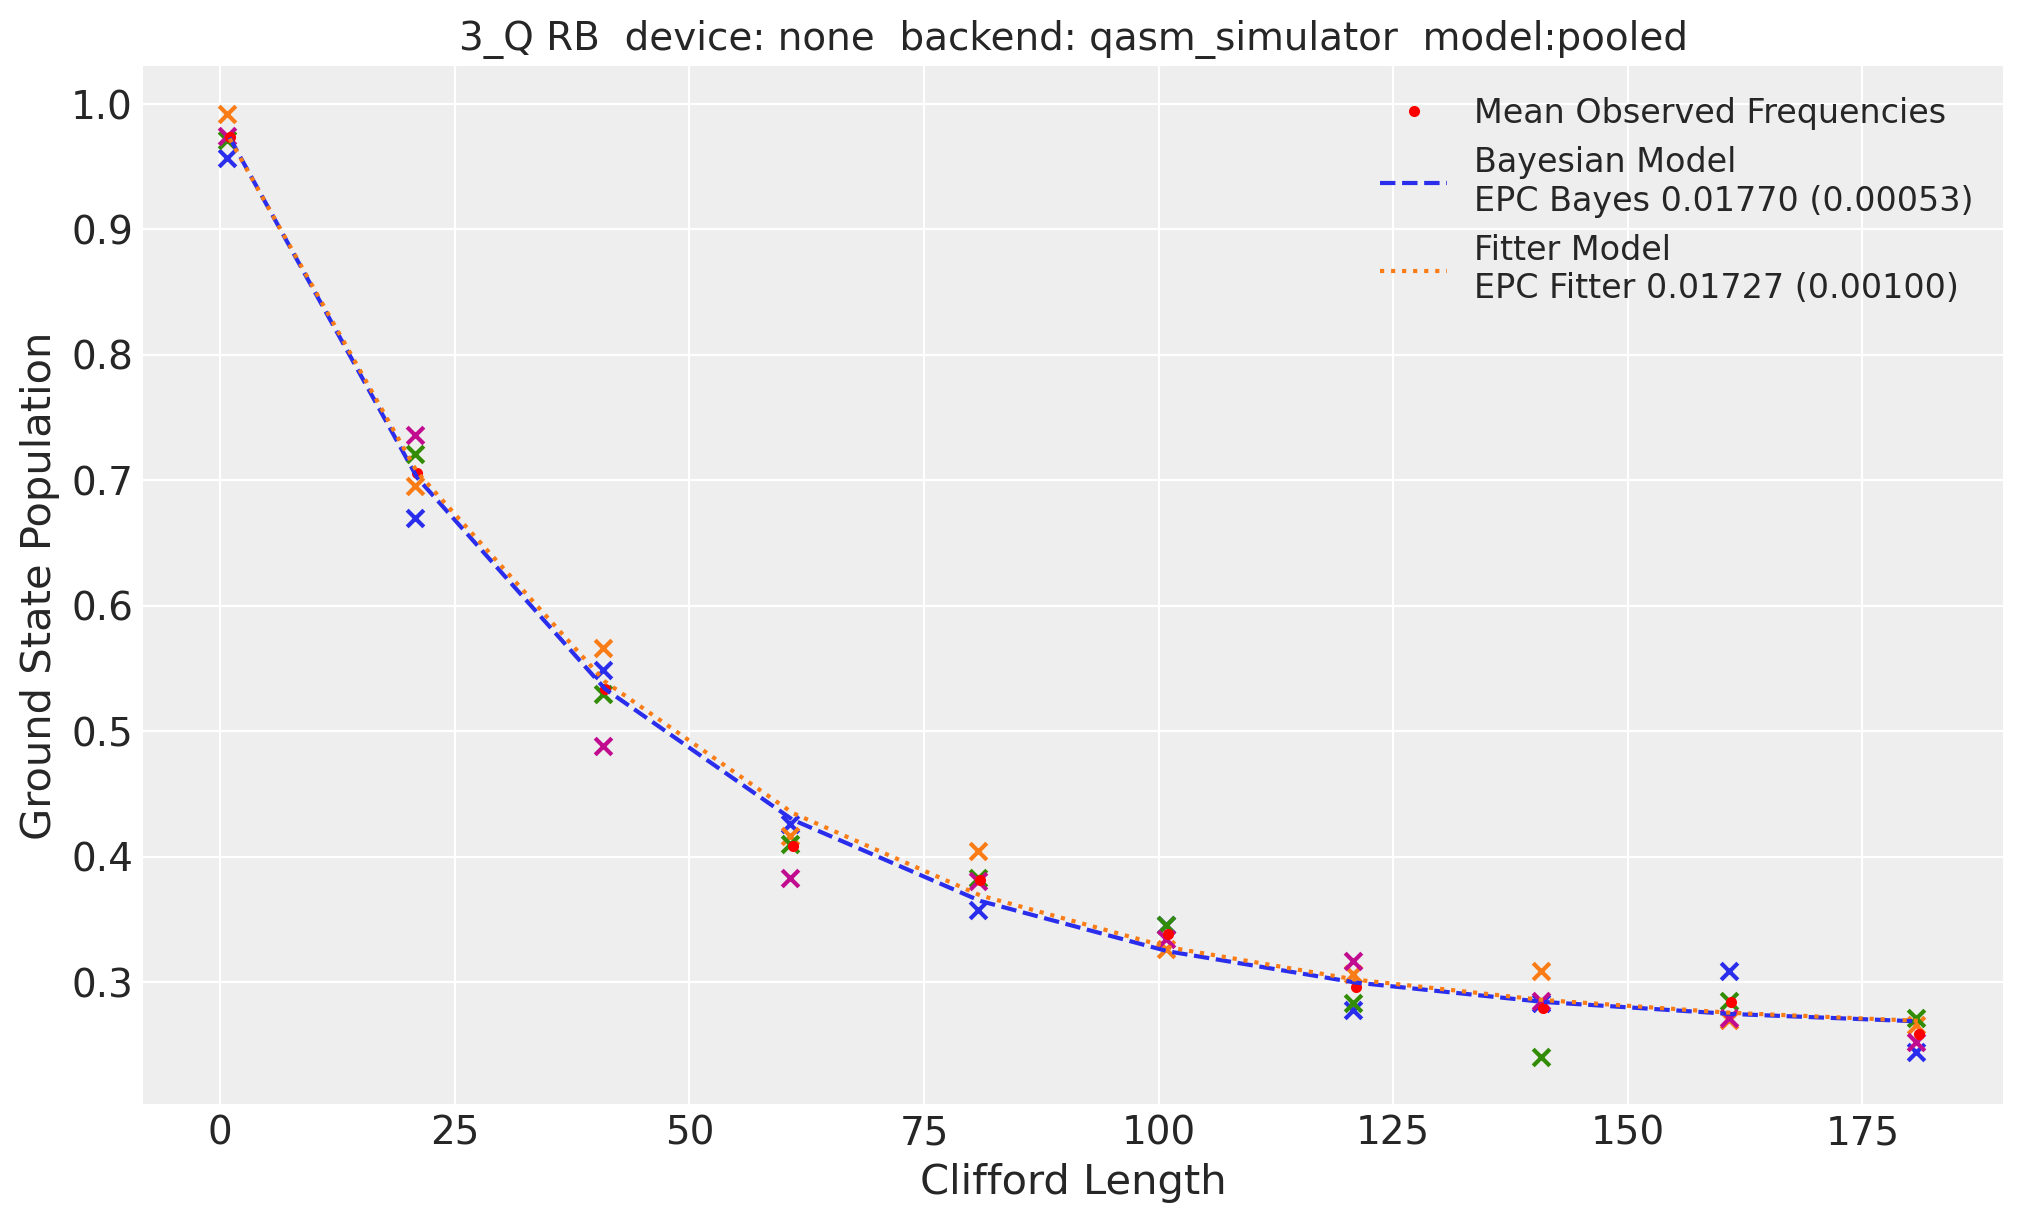

In [248]:
GSP_compare_fitter_to_bayes(pooled, azp_summary,m_name="pooled",rbfit = original_rb_fit)

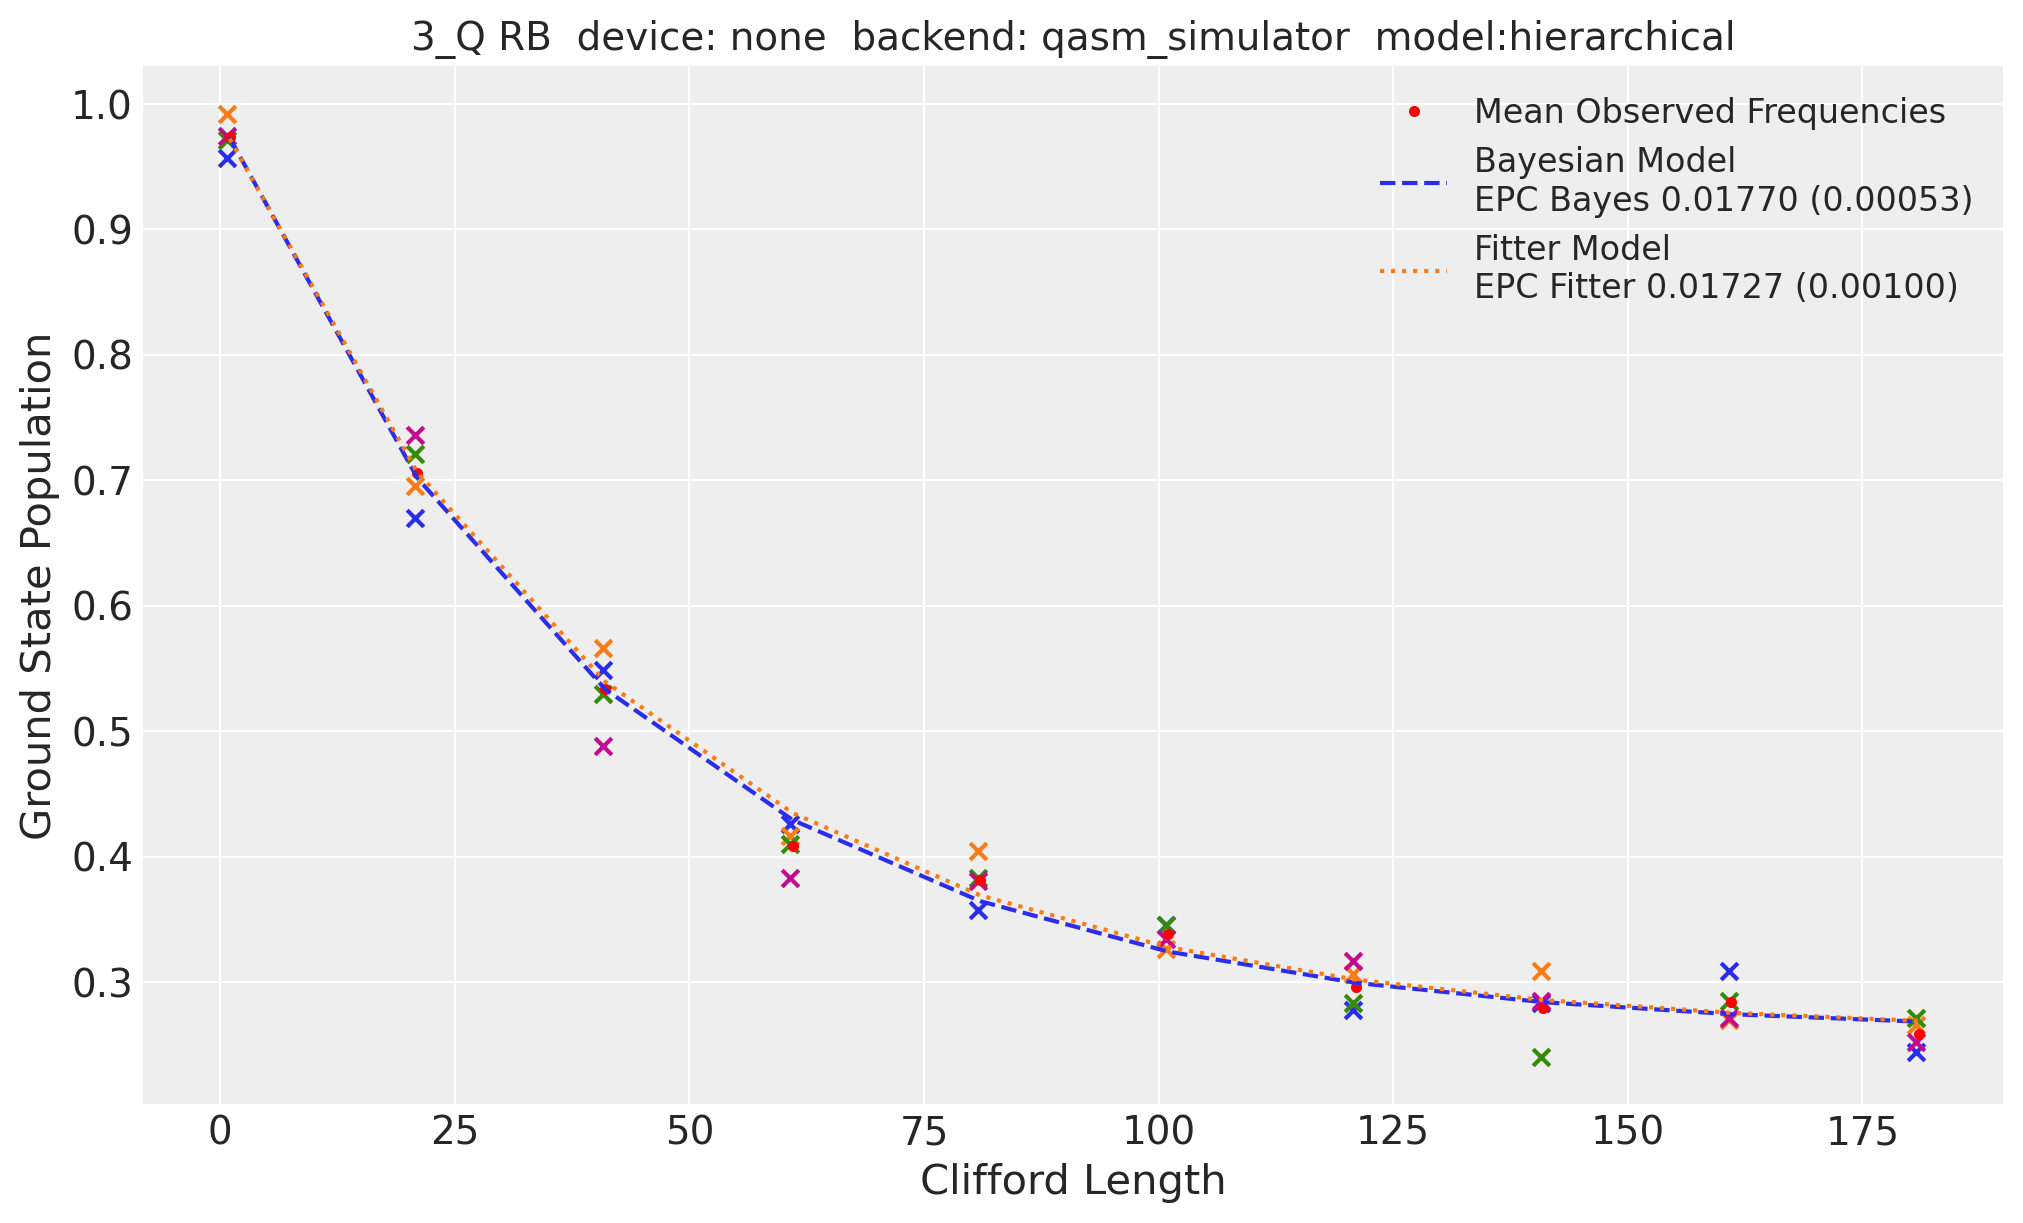

In [249]:
GSP_compare_fitter_to_bayes(hierarchical, azh_summary,m_name='hierarchical',rbfit = original_rb_fit)

In [250]:
alpha_original_p = azp_summary['mean']['alpha']
alpha_original_h = azh_summary['mean']['alpha']
alpha_original_p_err = azp_summary['sd']['alpha']
alpha_original_h_err = azh_summary['sd']['alpha']

## Interleaved

In [251]:
m_gates, Y, alpha_ref, alpha_lower, alpha_upper, mu_AB, cov_AB, sigma_theta =\
    obtain_priors_and_data_from_fitter(rbfit = interleaved_rb_fit, printout = True)

priors:
alpha_ref 0.9660110904132976
alpha_lower 0.9562295420414391 alpha_upper 0.9757926387851561
A,B [0.73679631 0.25008602] 
cov A,B [1.07757263e-04 4.80104965e-05]
sigma_theta 0.004


In [252]:
### a check of the count matrix # not working for 3 qubits WIP?
np.sum((Y == (get_count_data(interleaved_result_list)))*1) == Y.size

True

In [253]:
Y

array([[488, 321, 225, 168, 163, 146, 115, 136, 144, 128],
       [500, 314, 226, 160, 161, 140, 134, 131, 122, 135],
       [491, 298, 213, 177, 168, 154, 124, 128, 131, 112],
       [491, 313, 204, 174, 143, 146, 120, 111, 139, 124]])

### pooled model

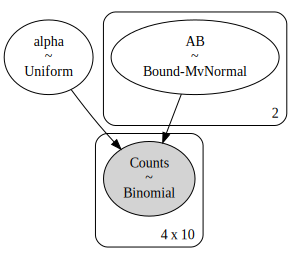

In [254]:
pooled = get_bayesian_model("pooled")
pm.model_to_graphviz(pooled)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [AB, alpha]


Sampling 4 chains for 10_000 tune and 2_000 draw iterations (40_000 + 8_000 draws total) took 72 seconds.


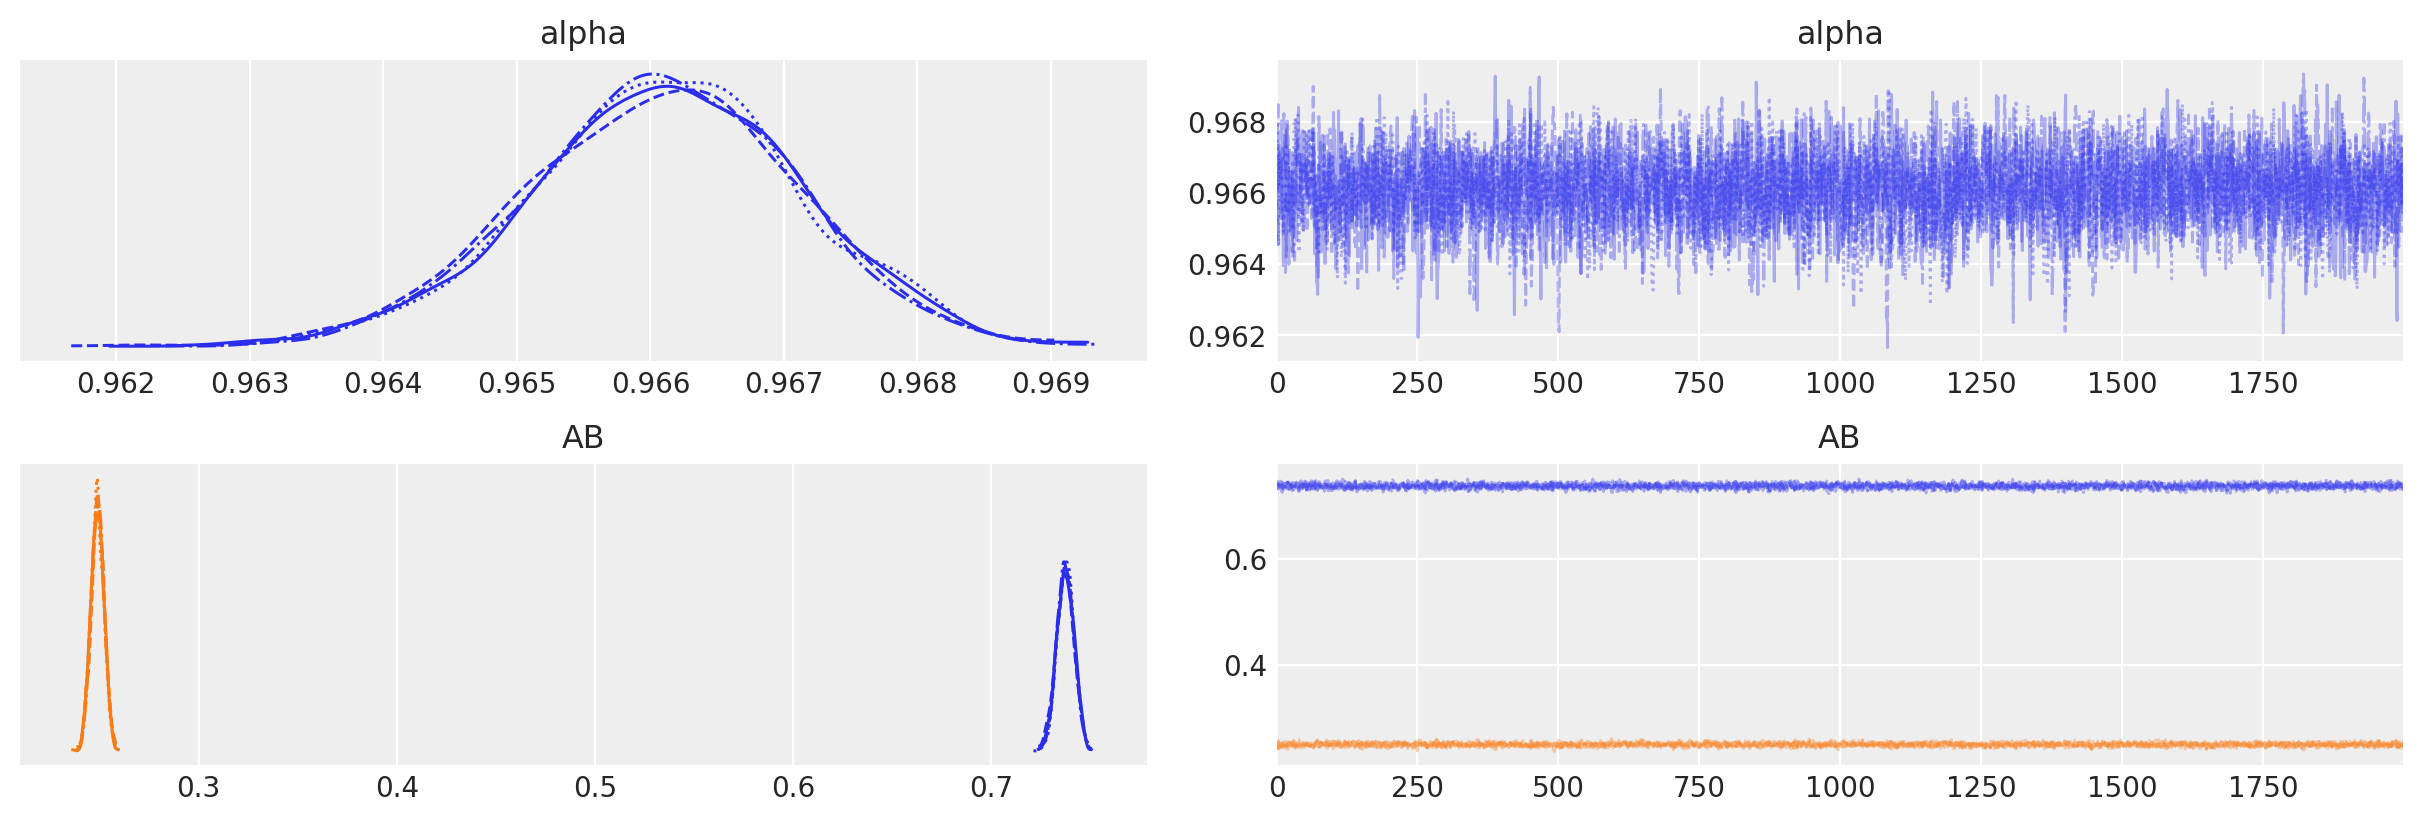

In [255]:
trace_p = get_trace(pooled)

In [256]:
azp_summary = get_summary(pooled, trace_p)
azp_summary

mean      sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd   ess_bulk  \
alpha  0.9661  0.0010  0.9643   0.9681     0.0000      0.0  4019.6585   
AB[0]  0.7374  0.0043  0.7294   0.7457     0.0001      0.0  4925.7898   
AB[1]  0.2490  0.0033  0.2427   0.2549     0.0001      0.0  3686.9440   

        ess_tail   r_hat  
alpha  3953.4879  1.0003  
AB[0]  5479.9548  1.0009  
AB[1]  4640.1401  1.0006

### hierarchical model

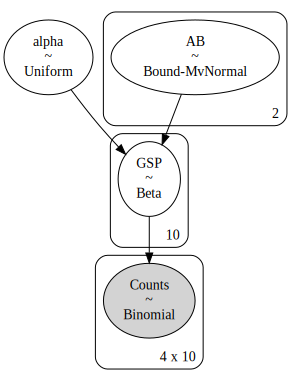

In [257]:
hierarchical = get_bayesian_model("hierarchical")
pm.model_to_graphviz(hierarchical)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [GSP, AB, alpha]


Sampling 4 chains for 10_000 tune and 2_000 draw iterations (40_000 + 8_000 draws total) took 118 seconds.


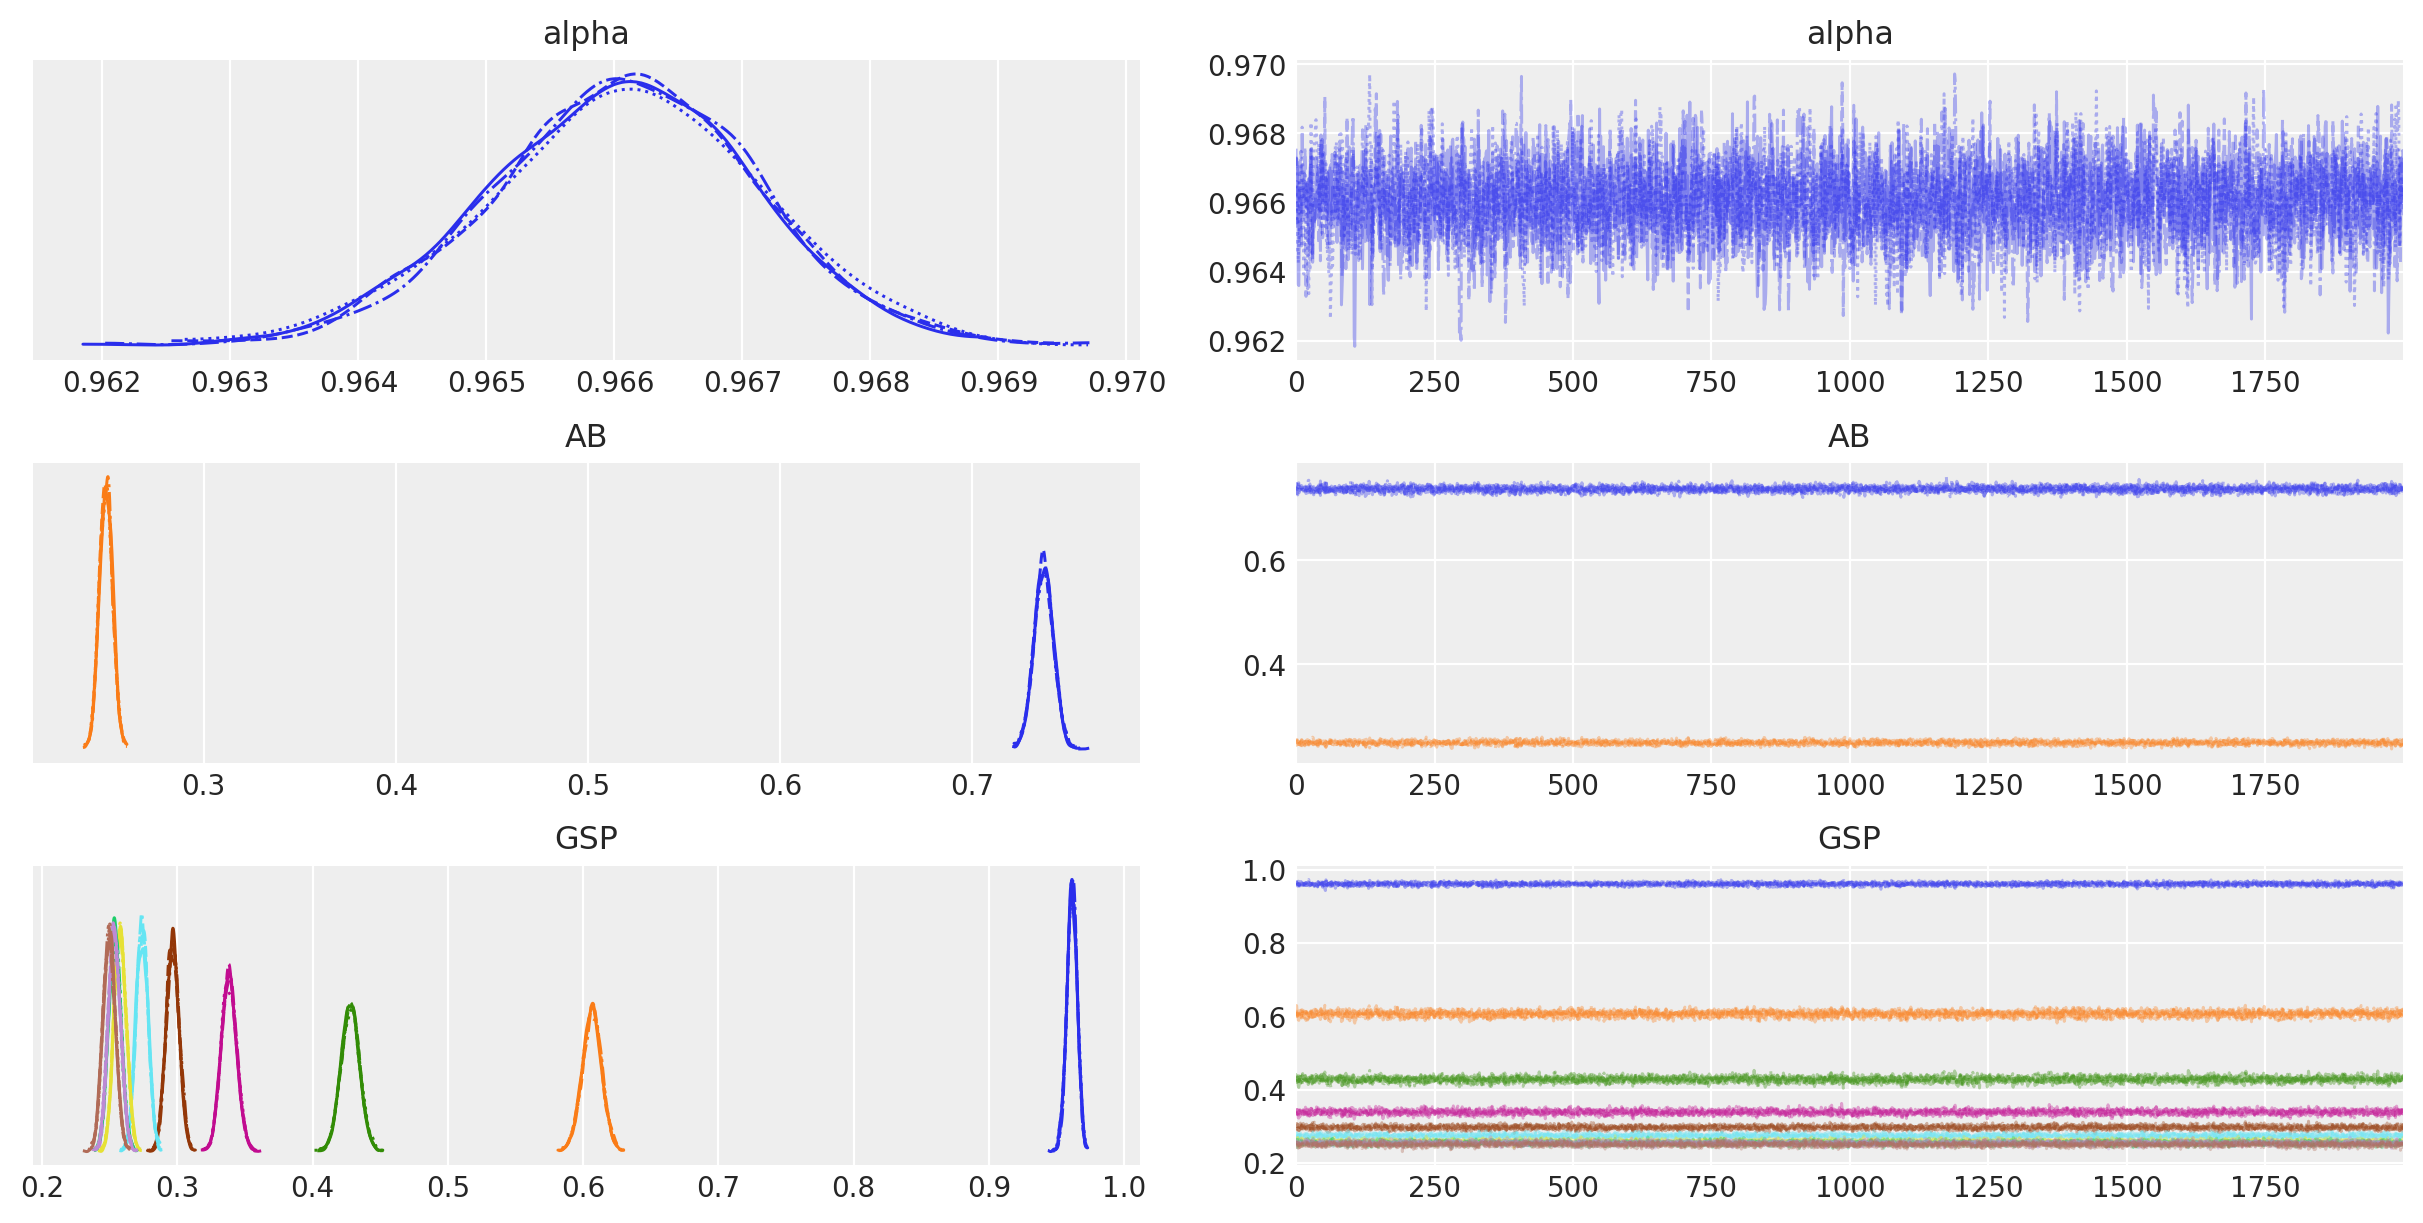

In [258]:
trace_h = get_trace(hierarchical)

In [259]:
azh_summary = get_summary(hierarchical, trace_h)
azh_summary

mean      sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd   ess_bulk  \
alpha   0.9661  0.0011  0.9640   0.9680     0.0000   0.0000  3510.4302   
AB[0]   0.7371  0.0050  0.7279   0.7467     0.0001   0.0000  5674.8239   
AB[1]   0.2492  0.0034  0.2429   0.2555     0.0001   0.0000  3665.9747   
GSP[0]  0.9615  0.0038  0.9543   0.9686     0.0000   0.0000  6959.6515   
GSP[1]  0.6066  0.0072  0.5926   0.6199     0.0001   0.0001  4007.4750   
GSP[2]  0.4279  0.0069  0.4145   0.4405     0.0001   0.0001  3976.8607   
GSP[3]  0.3382  0.0058  0.3272   0.3488     0.0001   0.0001  4309.9850   
GSP[4]  0.2965  0.0048  0.2877   0.3057     0.0001   0.0000  4986.9251   
GSP[5]  0.2739  0.0045  0.2656   0.2822     0.0001   0.0000  5036.4668   
GSP[6]  0.2577  0.0045  0.2491   0.2659     0.0001   0.0000  5164.3622   
GSP[7]  0.2538  0.0046  0.2450   0.2621     0.0001   0.0000  5452.7654   
GSP[8]  0.2535  0.0045  0.2450   0.2618     0.0001   0.0000  5187.2898   
GSP[9]  0.2496  0.0046  0.2412   0.2584     0.0001   0.0000  4984.5144   

         ess_tail   r_hat  
alpha   4272.6449  1.0003  
AB[0]   5885.1593  1.0002  
AB[1]   5148.5748  1.0002  
GSP[0]  5671.5393  1.0006  
GSP[1]  4791.0668  1.0000  
GSP[2]  4839.0970  1.0002  
GSP[3]  5550.0086  1.0000  
GSP[4]  5249.6035  1.0004  
GSP[5]  5233.4086  1.0022  
GSP[6]  5627.6829  1.0001  
GSP[7]  5742.2733  1.0001  
GSP[8]  6171.1411  1.0003  
GSP[9]  5786.3115  1.0002

### compare models
ref: https://docs.pymc.io/notebooks/model_comparison.html

In [260]:
# Leave-one-out Cross-validation (LOO) comparison
df_comp_loo = az.compare({"hierarchical": trace_h, "pooled": trace_p})
df_comp_loo

C:\Users\decpi\Anaconda3\envs\QK20\lib\site-packages\arviz\stats\stats.py:145: UserWarning: The default method used to estimate the weights for each model,has changed from BB-pseudo-BMA to stacking
  warnings.warn(


rank         loo    p_loo     d_loo        weight        se  \
hierarchical     0 -147.607266  3.07686  0.000000  1.000000e+00  3.477226   
pooled           1 -148.067875  2.10651  0.460609  5.551115e-16  3.678723   

                   dse  warning loo_scale  
hierarchical  0.000000    False       log  
pooled        0.388815    False       log

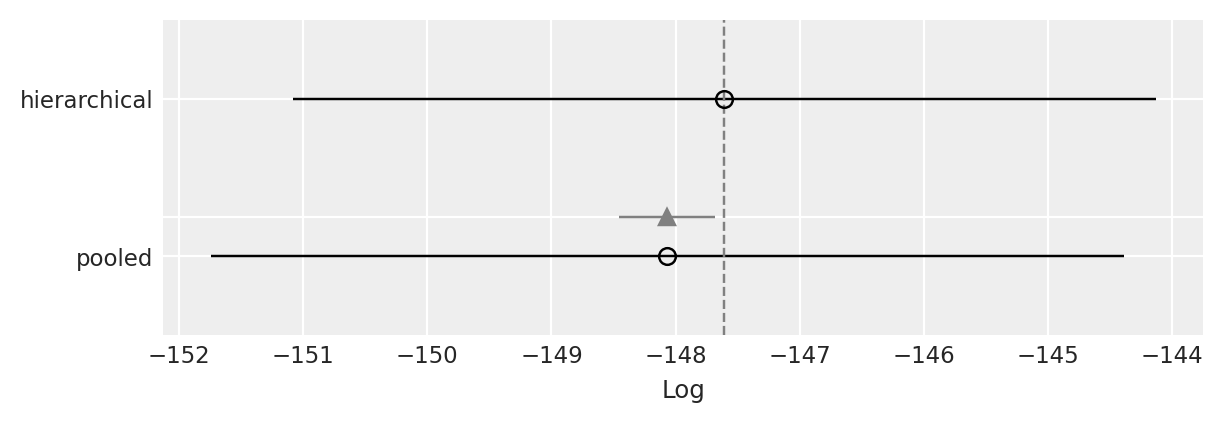

In [261]:
az.plot_compare(df_comp_loo, insample_dev=False);

In [262]:
# predict EPC from the noisy model # not for real device!

pred_epc = -1 # will not appear on graphs for real device but at this point functions need value (WIP)

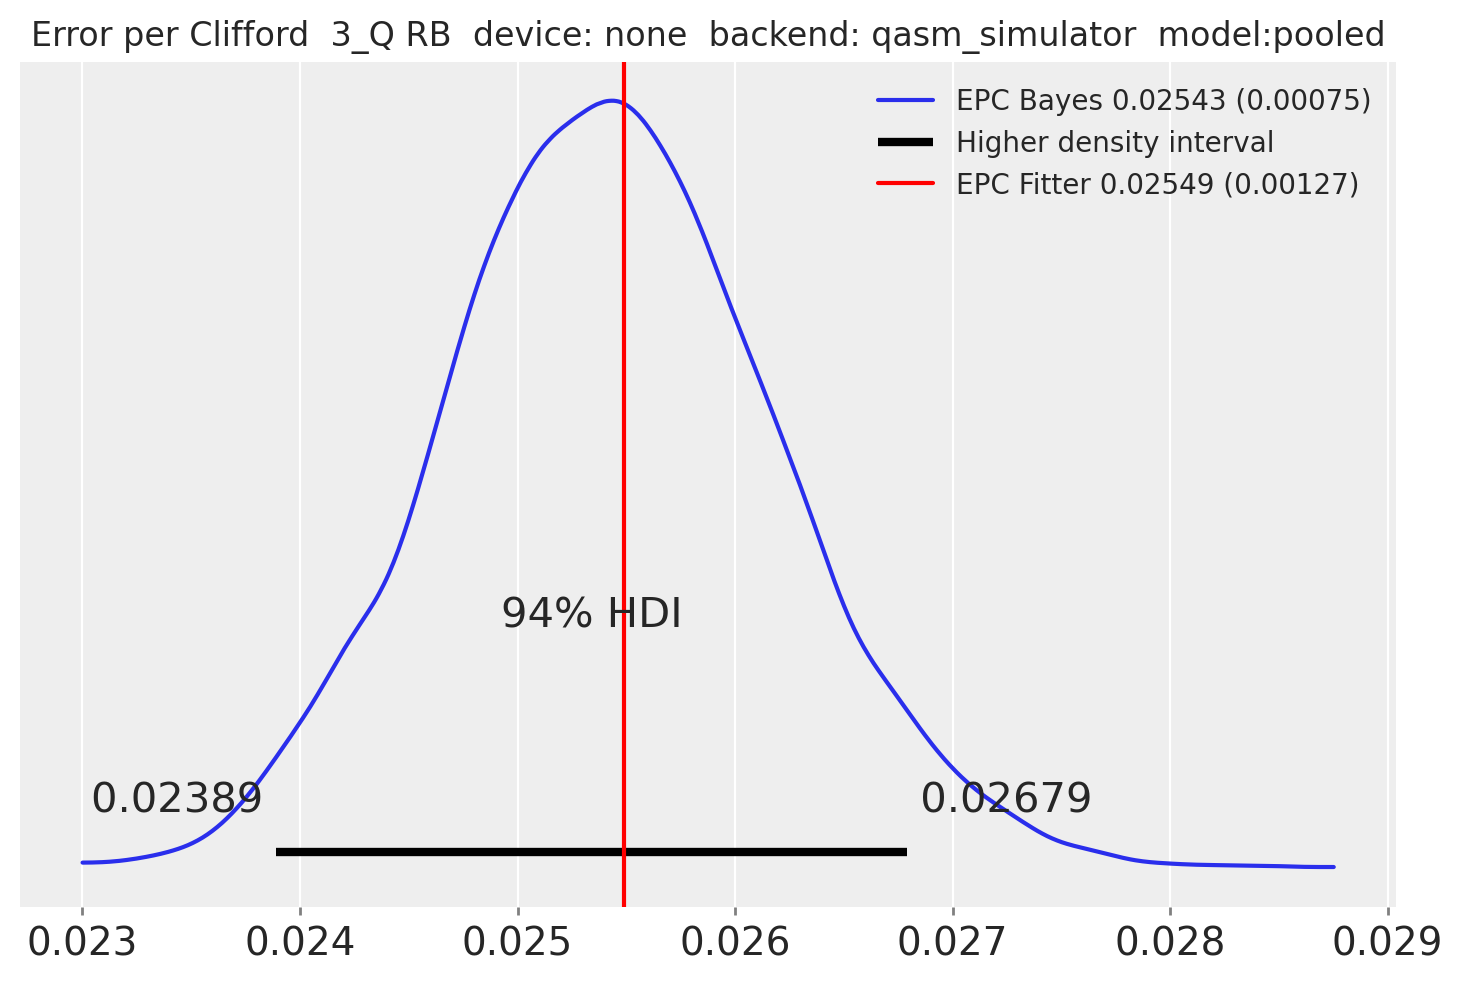

In [263]:
EPC_compare_fitter_to_bayes(pooled, azp_summary, trace_p, m_name="pooled",rbfit = interleaved_rb_fit)

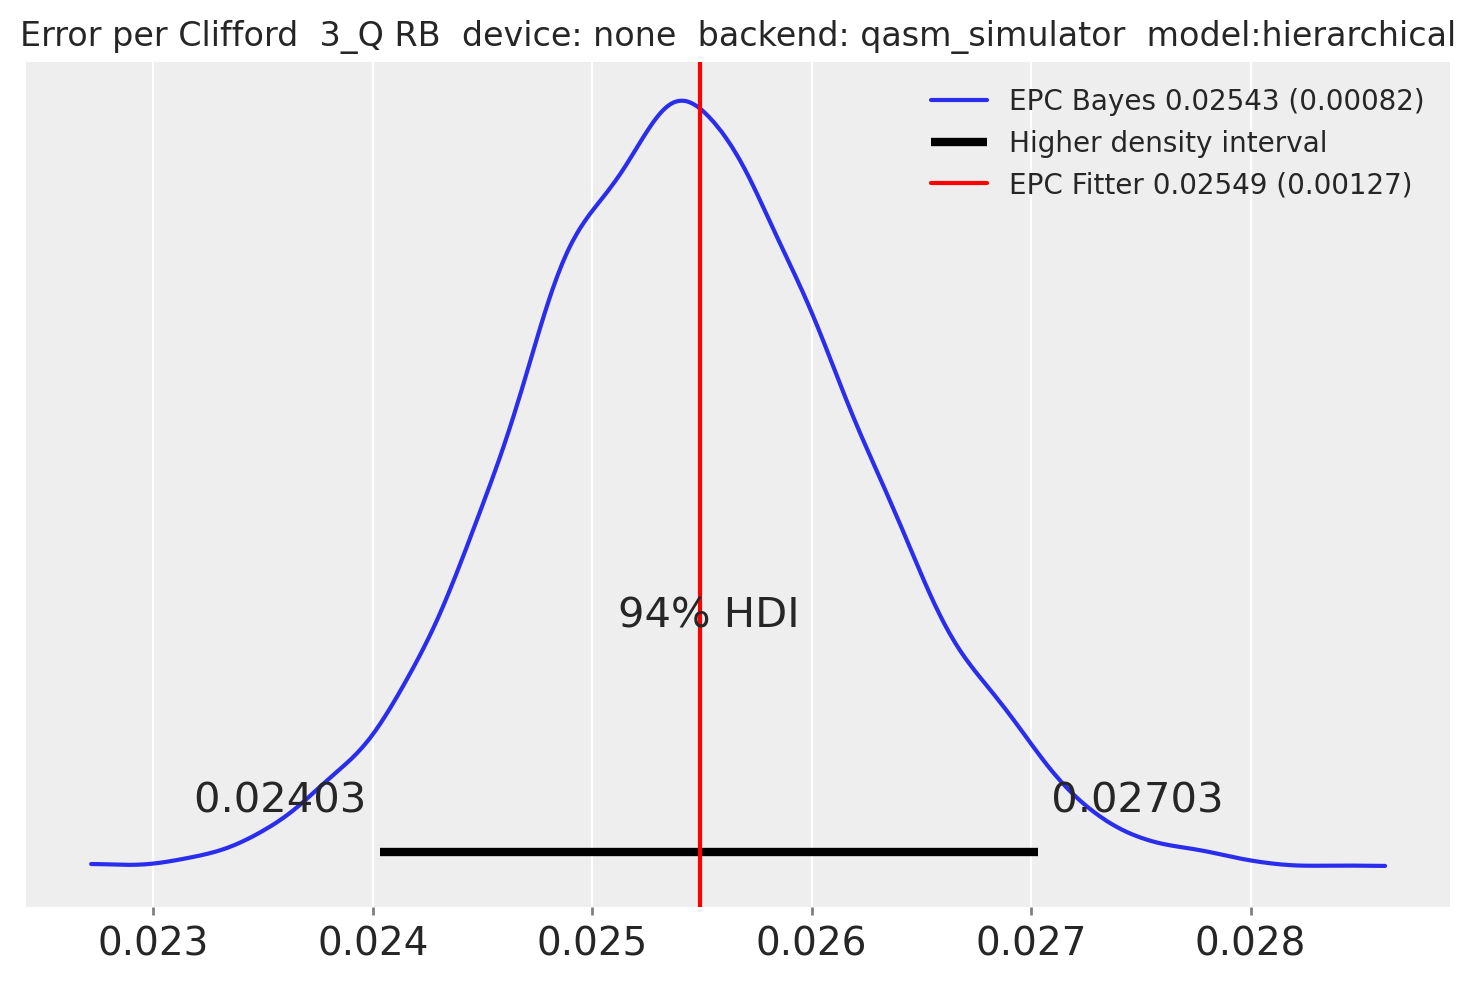

In [264]:
EPC_compare_fitter_to_bayes(hierarchical, azh_summary, trace_h,m_name='hierarchical',rbfit = interleaved_rb_fit,)

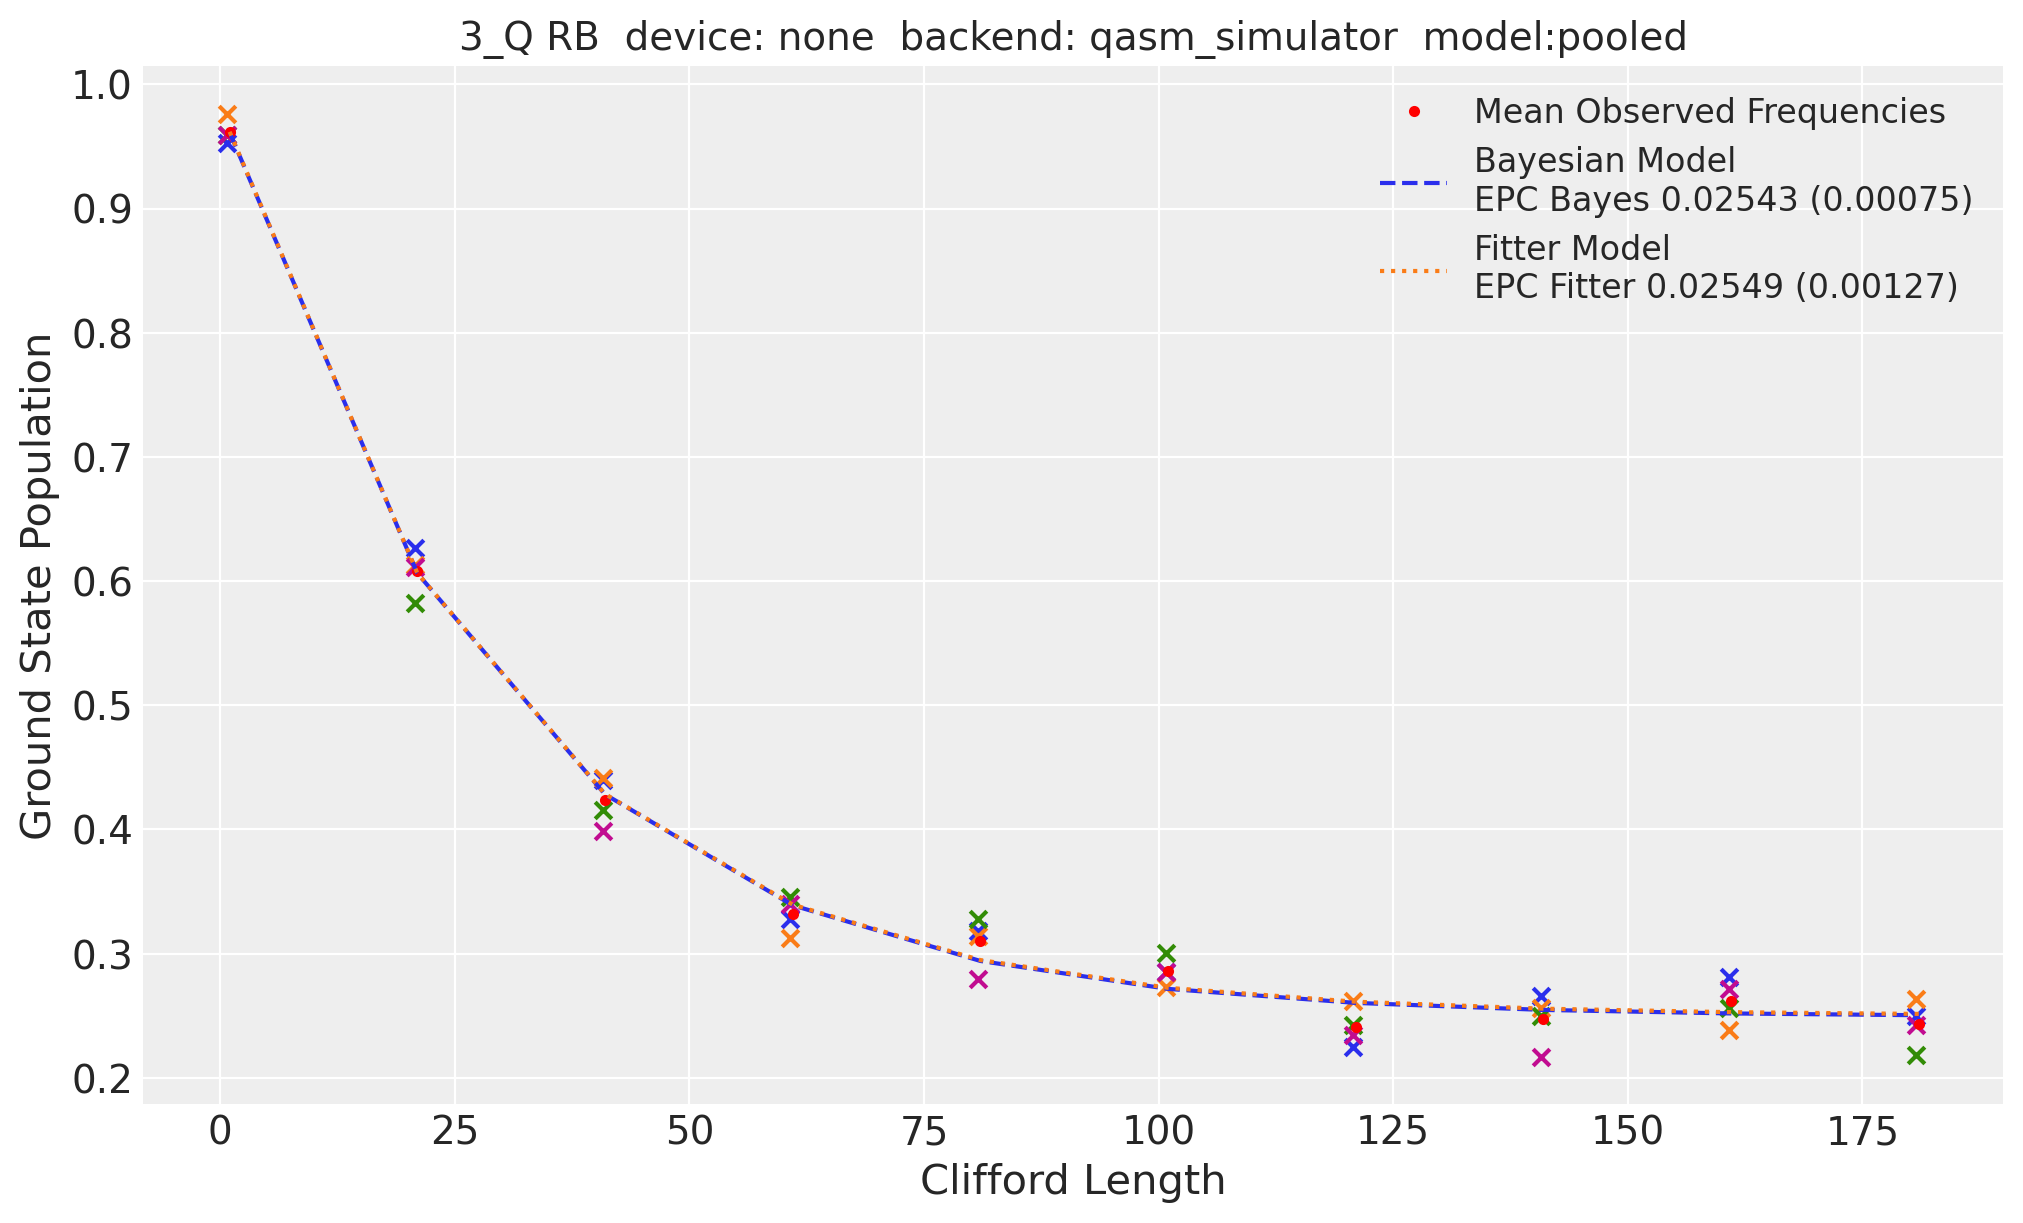

In [265]:
GSP_compare_fitter_to_bayes(pooled, azp_summary,m_name="pooled",rbfit = interleaved_rb_fit)

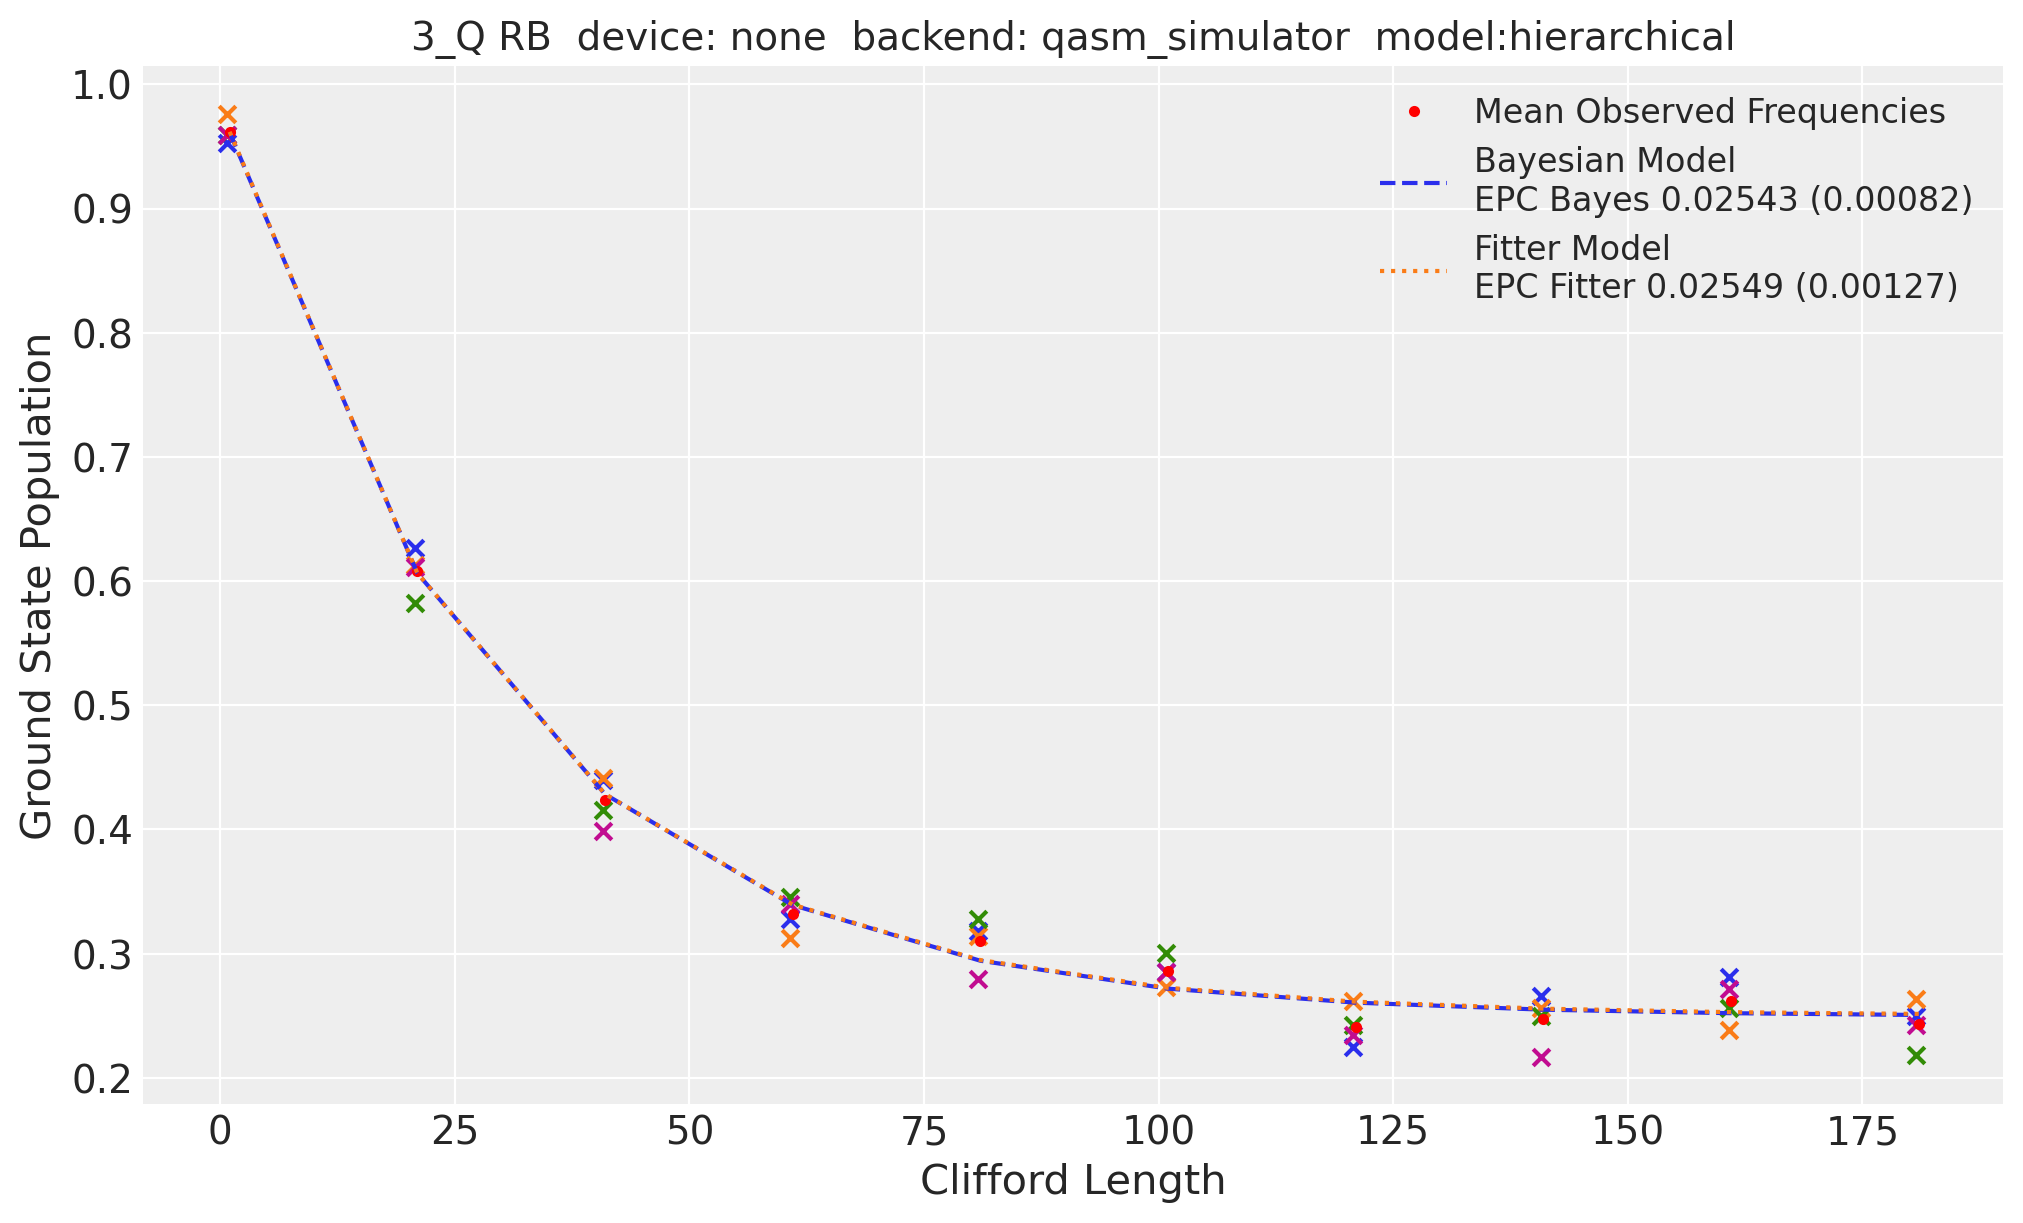

In [266]:
GSP_compare_fitter_to_bayes(hierarchical, azh_summary,m_name='hierarchical',rbfit = interleaved_rb_fit)

### Calculate the interleaved gate error fidelity

From the values of $\alpha$ and $\alpha_C$ we obtain the gate error of the interleaved Clifford $c$, and $r_C=1-$(average gate fidelity of the interleaved Clifford $C$), is estimated by:
$$ EPC^{est} = r_C^{est} = \frac{(2^n-1)(1-\alpha_C/\alpha)}{2^n}$$
and must lie in the range given by certain systematic error bounds: 
$$[r_C^{est}-E,r_C^{est}+E]$$ 
for each of the patterns.

In [279]:
alpha_c_p = azp_summary['mean']['alpha']
alpha_c_h = azh_summary['mean']['alpha']
alpha_c_p_err = azp_summary['sd']['alpha']
alpha_c_h_err = azh_summary['sd']['alpha']

In [289]:
azp_summary

mean      sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd   ess_bulk  \
alpha  0.9661  0.0010  0.9643   0.9681     0.0000      0.0  4019.6585   
AB[0]  0.7374  0.0043  0.7294   0.7457     0.0001      0.0  4925.7898   
AB[1]  0.2490  0.0033  0.2427   0.2549     0.0001      0.0  3686.9440   

        ess_tail   r_hat  
alpha  3953.4879  1.0003  
AB[0]  5479.9548  1.0009  
AB[1]  4640.1401  1.0006

In [290]:
azh_summary

mean      sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd   ess_bulk  \
alpha   0.9661  0.0011  0.9640   0.9680     0.0000   0.0000  3510.4302   
AB[0]   0.7371  0.0050  0.7279   0.7467     0.0001   0.0000  5674.8239   
AB[1]   0.2492  0.0034  0.2429   0.2555     0.0001   0.0000  3665.9747   
GSP[0]  0.9615  0.0038  0.9543   0.9686     0.0000   0.0000  6959.6515   
GSP[1]  0.6066  0.0072  0.5926   0.6199     0.0001   0.0001  4007.4750   
GSP[2]  0.4279  0.0069  0.4145   0.4405     0.0001   0.0001  3976.8607   
GSP[3]  0.3382  0.0058  0.3272   0.3488     0.0001   0.0001  4309.9850   
GSP[4]  0.2965  0.0048  0.2877   0.3057     0.0001   0.0000  4986.9251   
GSP[5]  0.2739  0.0045  0.2656   0.2822     0.0001   0.0000  5036.4668   
GSP[6]  0.2577  0.0045  0.2491   0.2659     0.0001   0.0000  5164.3622   
GSP[7]  0.2538  0.0046  0.2450   0.2621     0.0001   0.0000  5452.7654   
GSP[8]  0.2535  0.0045  0.2450   0.2618     0.0001   0.0000  5187.2898   
GSP[9]  0.2496  0.0046  0.2412   0.2584     0.0001   0.0000  4984.5144   

         ess_tail   r_hat  
alpha   4272.6449  1.0003  
AB[0]   5885.1593  1.0002  
AB[1]   5148.5748  1.0002  
GSP[0]  5671.5393  1.0006  
GSP[1]  4791.0668  1.0000  
GSP[2]  4839.0970  1.0002  
GSP[3]  5550.0086  1.0000  
GSP[4]  5249.6035  1.0004  
GSP[5]  5233.4086  1.0022  
GSP[6]  5627.6829  1.0001  
GSP[7]  5742.2733  1.0001  
GSP[8]  6171.1411  1.0003  
GSP[9]  5786.3115  1.0002

In [280]:
alpha_original_p

0.9764

In [281]:
alpha_c_p

0.9661

In [282]:
epc_est_p = 3*(1 - alpha_c_p/alpha_original_p)/4
epc_est_p

0.007911716509627298

In [283]:
epc_est_p_err = 3*(alpha_c_p/alpha_original_p)/4*(np.sqrt(alpha_original_p_err**2 + alpha_c_p_err**2))
epc_est_p_err 

0.0009058341904209593

In [287]:
alpha_original_h

0.9764

In [288]:
alpha_c_h

0.9661

In [284]:
epc_est_h = 3*(1 - alpha_c_h/alpha_original_h)/4
epc_est_h

0.007911716509627298

In [286]:
epc_est_h_err = 3*(alpha_c_h/alpha_original_h)/4*(np.sqrt(alpha_original_h_err**2 + alpha_c_h_err**2))
epc_est_h_err 

0.0009675647445206286

### Bayesian results to be compared with:

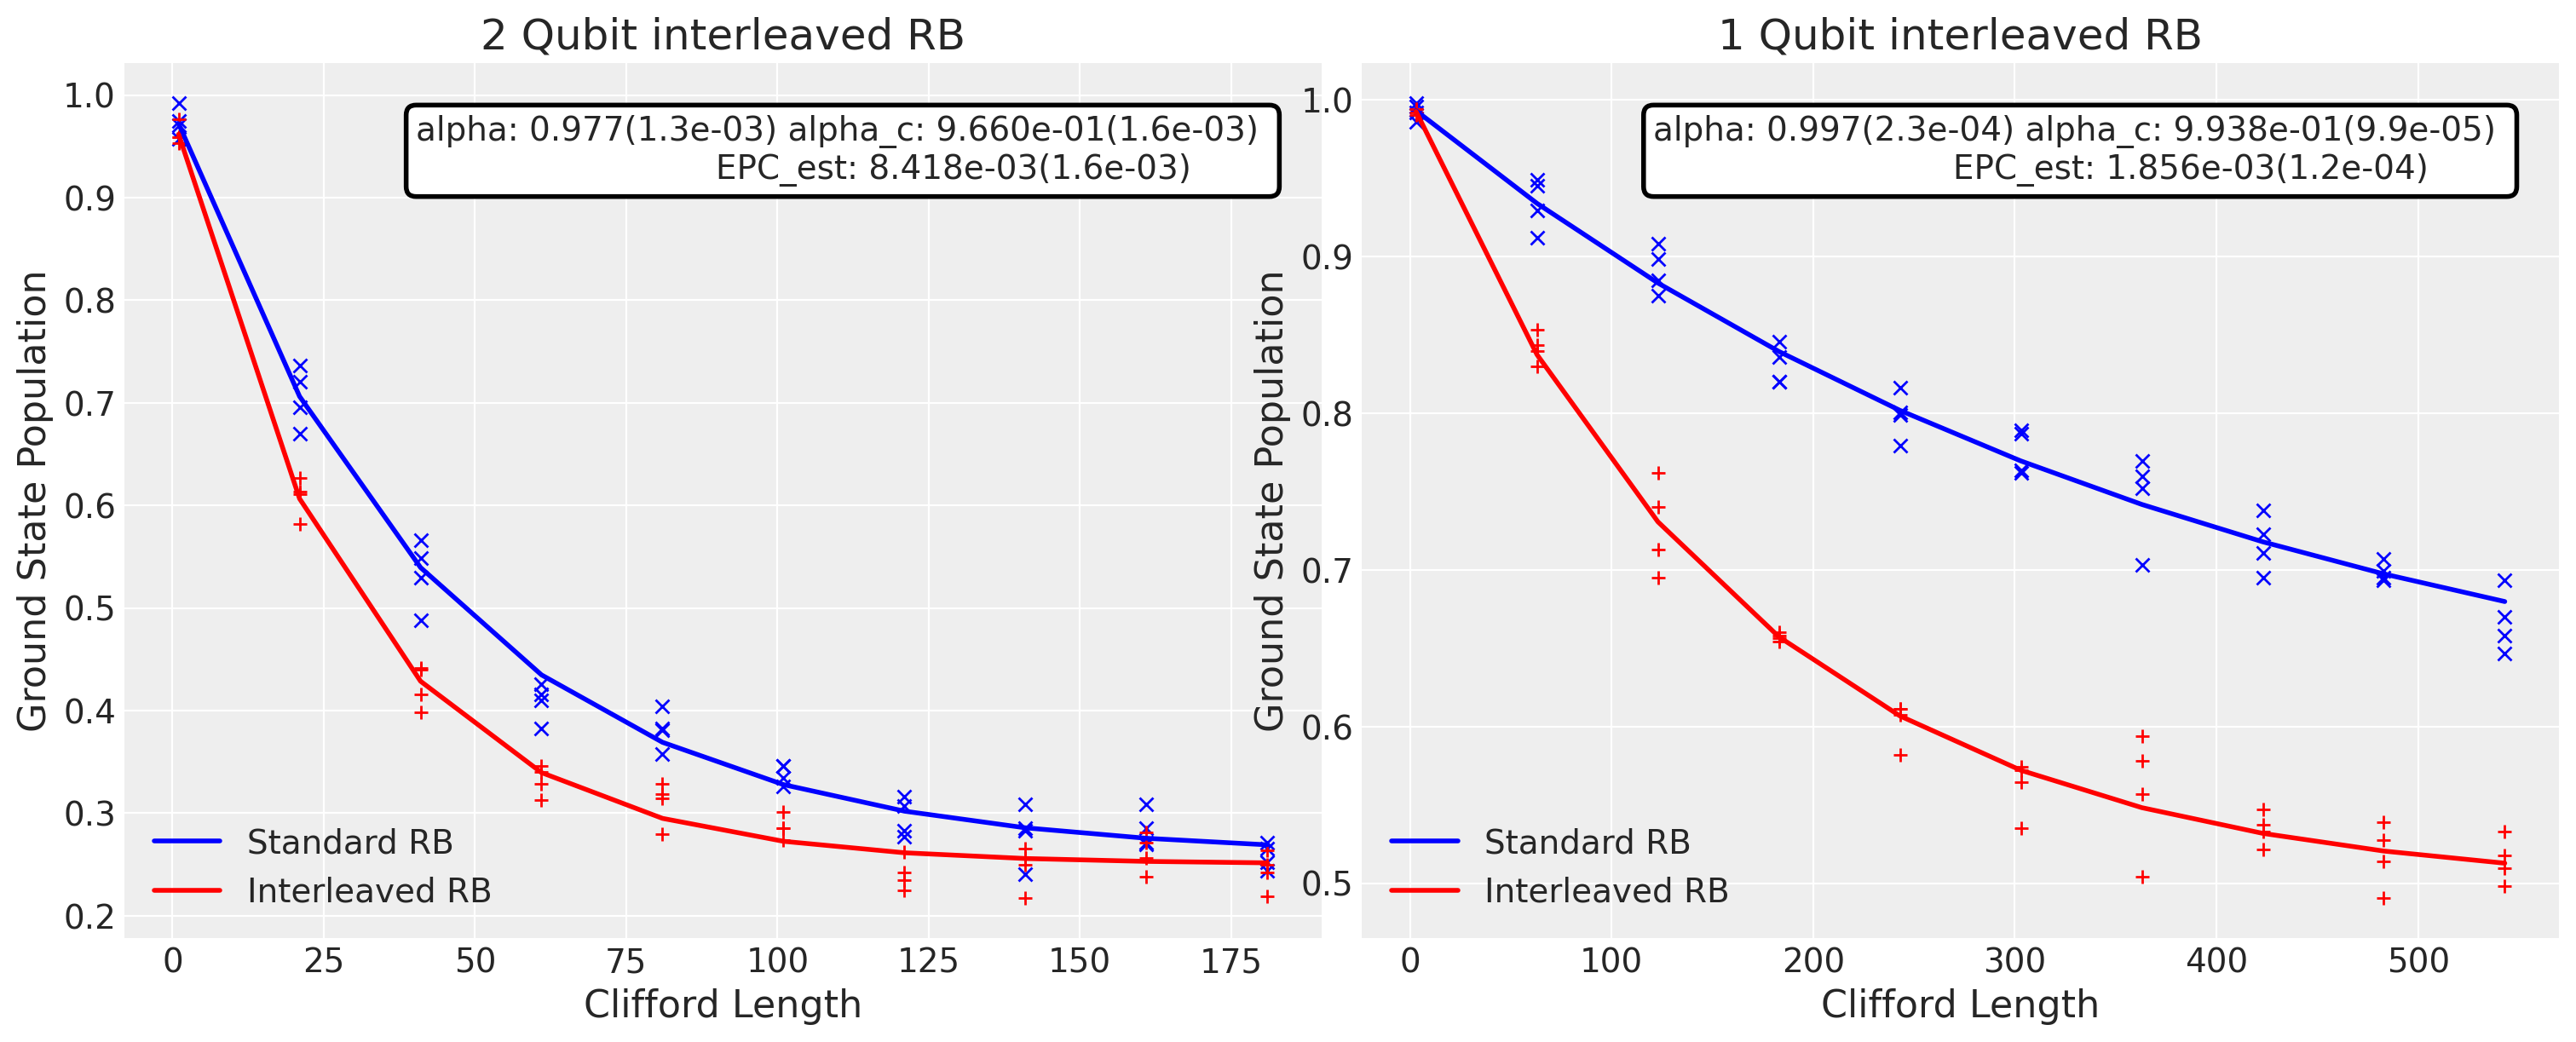

In [272]:
#Plot the joint RB data
plt.figure(figsize=(15, 6))

for i in range(2):
    ax = plt.subplot(1, 2, i+1)
    pattern_ind = i

    # Plot the essence by calling plot_rb_data
    joint_rb_fit.plot_rb_data(pattern_ind, ax=ax, add_label=True, show_plt=False)

    # Add title and label
    ax.set_title('%d Qubit interleaved RB'%(len(rb_opts['rb_pattern'][i])), fontsize=18)

plt.show()

#### verify the EPC_est error calculation
from: rb.InterleavedRBFitter

epc_est_err = ((nrb - 1) / nrb) * (alpha_c / alpha) \
                * (np.sqrt(alpha_err_sq + alpha_c_err_sq))

In [273]:
3*(1 -0.966/0.977)/4

0.00844421699078815

In [239]:
3*(0.9769767887374156/0.9660110904132976)/4*(np.sqrt(0.0013008607689118682**2 + 0.0016302580619764167**2))

0.001582002011137519

In [274]:
import qiskit.tools.jupyter
%qiskit_version_table
%qiskit_copyright

In [275]:
%load_ext watermark
%watermark -n -u -v -iv -w

The watermark extension is already loaded. To reload it, use:
  %reload_ext watermark
Last updated: Wed Apr 07 2021

Python implementation: CPython
Python version       : 3.8.1
IPython version      : 7.12.0

numpy     : 1.18.1
matplotlib: 3.3.1
qiskit    : 0.23.0
pymc3     : 3.11.1
IPython   : 7.12.0
arviz     : 0.11.2

Watermark: 2.2.0

